In [2]:
import numpy as np
import pandas as pd
import doubleml as dml
import seaborn as sns
import matplotlib.pyplot as plt

from doubleml.datasets import make_plr_CCDDHNR2018

from sklearn.linear_model import Lasso, LassoCV
from sklearn.base import clone

from scipy import stats
from tqdm import tqdm

from utils import make_data_list, make_BCH2014_data_list
from utils import simulate_lasso_plr, plot_lasso_score
from utils import plot_lasso_variation_results, plot_lasso_abs_bias, plot_lasso_coverage,\
                  plot_bias_coverage_next_to_eachother
from utils import cover_true, coverage, abs_bias

from scipy.linalg import toeplitz

import itertools

np.random.seed(1312)

# 1. Data and Model Preparation

## 1.1 DGP based on CCDDHNR2018

In [3]:
n_rep = 300
n_obs = 500
n_vars = 20
alpha = 0.5

data = make_data_list(n_rep=n_rep, n_obs=n_obs, n_vars=n_vars, model_type='plr', alpha=alpha)

lasso_alpha_hyperparams_ml_l = [0.001, 0.01, 0.1, 1]
lasso_alpha_hyperparams_ml_m = [0.001, 0.01, 0.1, 1]
n_folds = 5

## 1.2 DGP based on BCH2014

In [4]:
n_rep_BCH14 = 300
theta_BCH14 = 0.5 
n_obs_BCH14 = 100
dim_x_BCH14 = 200 
rho_BCH14 = 0.5
R2_d_BCH14 = 0.5 
R2_y_BCH14 = 0.5 
design_BCH14 = '1a'

random_seed_BCH14 = 1312

data_BCH14 = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_BCH14, dim_x=dim_x_BCH14,
                                    rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

# 2. Simulation and Hyperparameter Variation

## 2.1 DGB 1: CCDDHNR2018

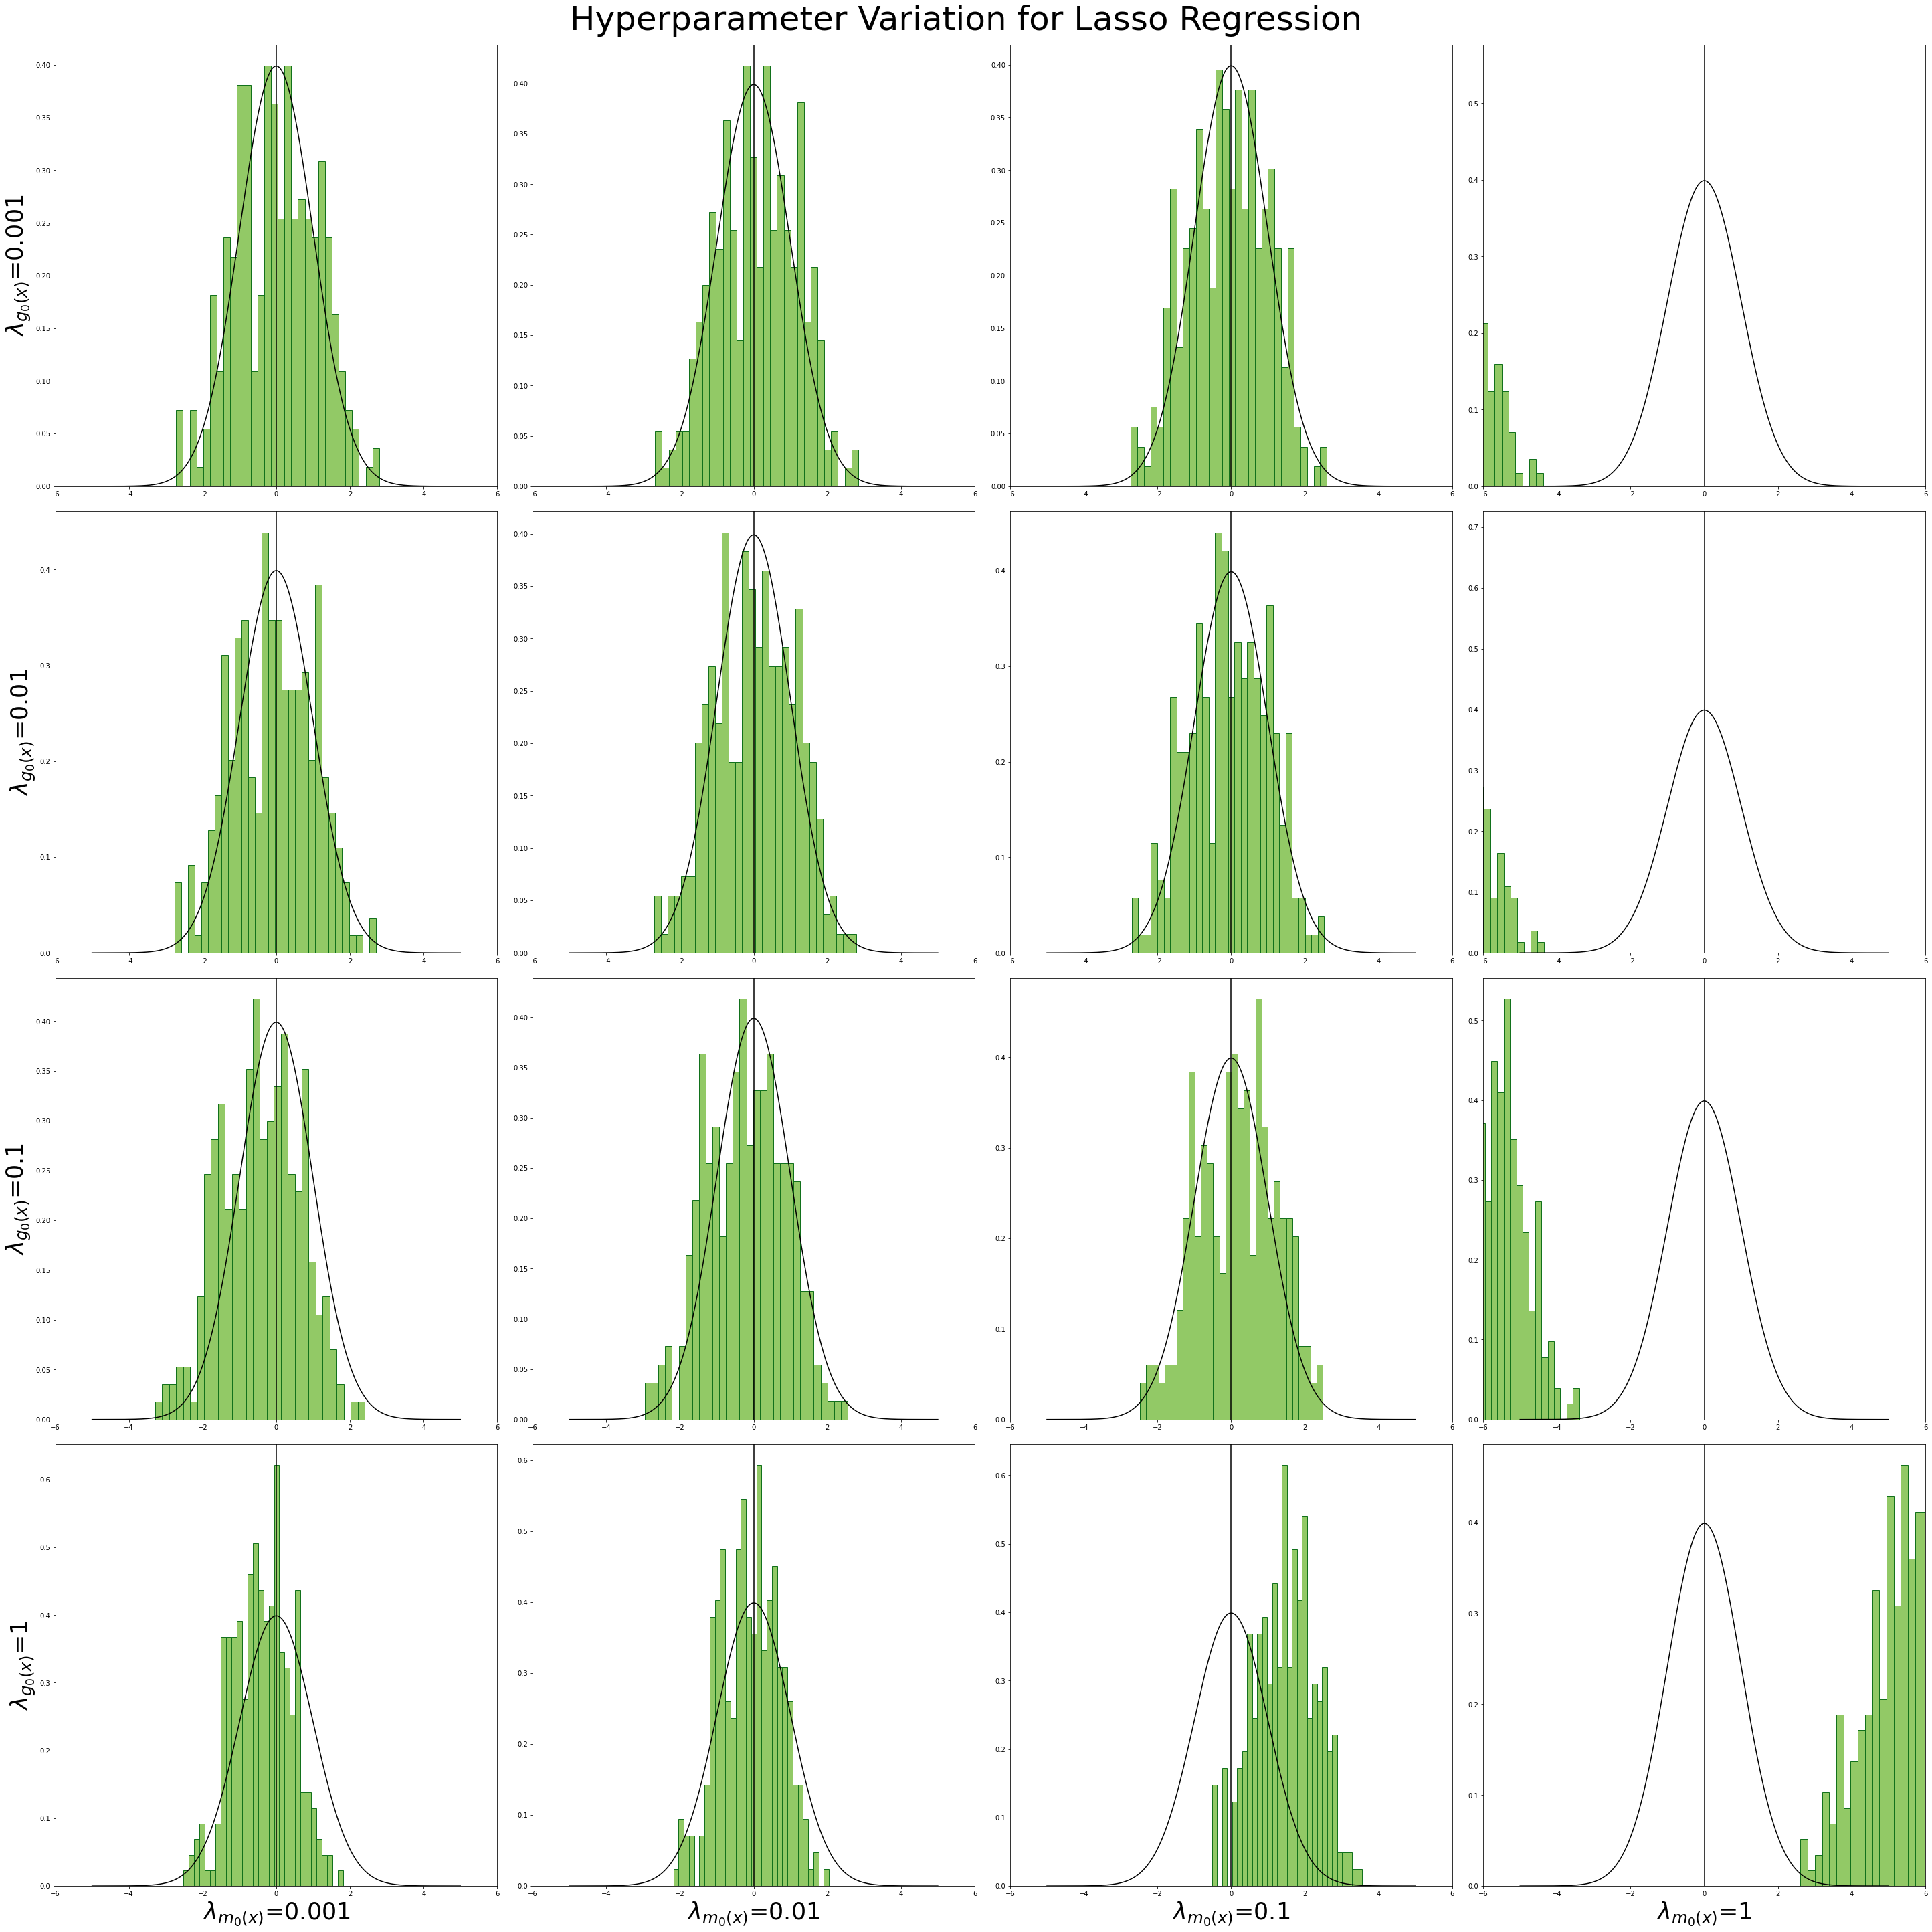

In [9]:
coverage_CCDNR2018, bias_CCDNR2018= plot_lasso_variation_results(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l,
                                                                 ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                                                 n_folds=n_folds, data=data, true_alpha=alpha,
                                                                 filename="lasso_hyperparameter_variation_CCDDHNR2018.png")

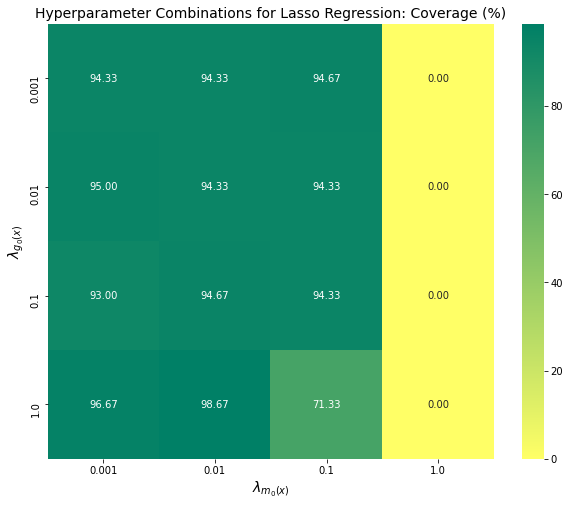

In [10]:
plot_lasso_coverage(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    coverage_scores=coverage_CCDNR2018,
                    filename="lasso_hyperparameters_coverage.png")

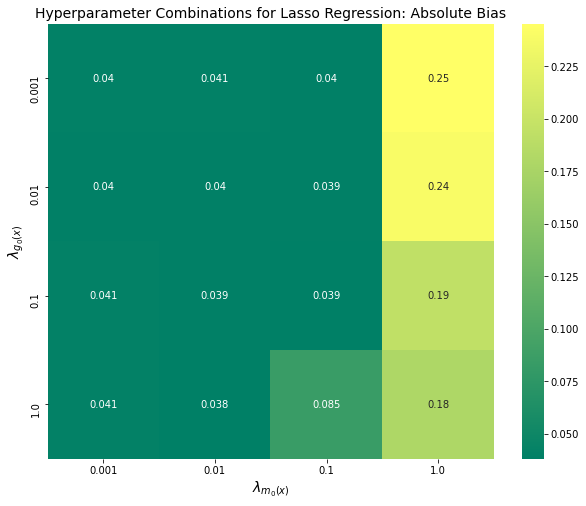

In [11]:
plot_lasso_abs_bias(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    bias_scores=bias_CCDNR2018,
                    filename="lasso_hyperparameters_bias.png")

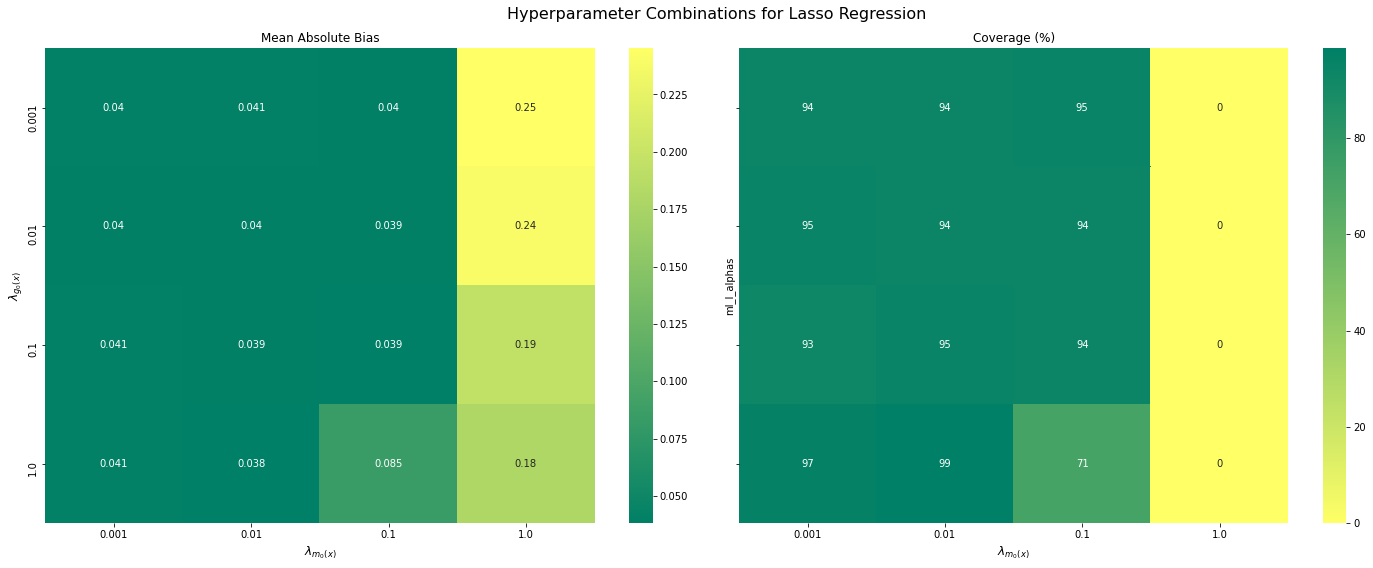

In [12]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                                     ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                     bias_scores=bias_CCDNR2018,
                                     coverage_scores=coverage_CCDNR2018,
                                     filename="lasso_hyperparameters_bias_and_coverage.png")

## 2.2 DGP 2: BCH2014

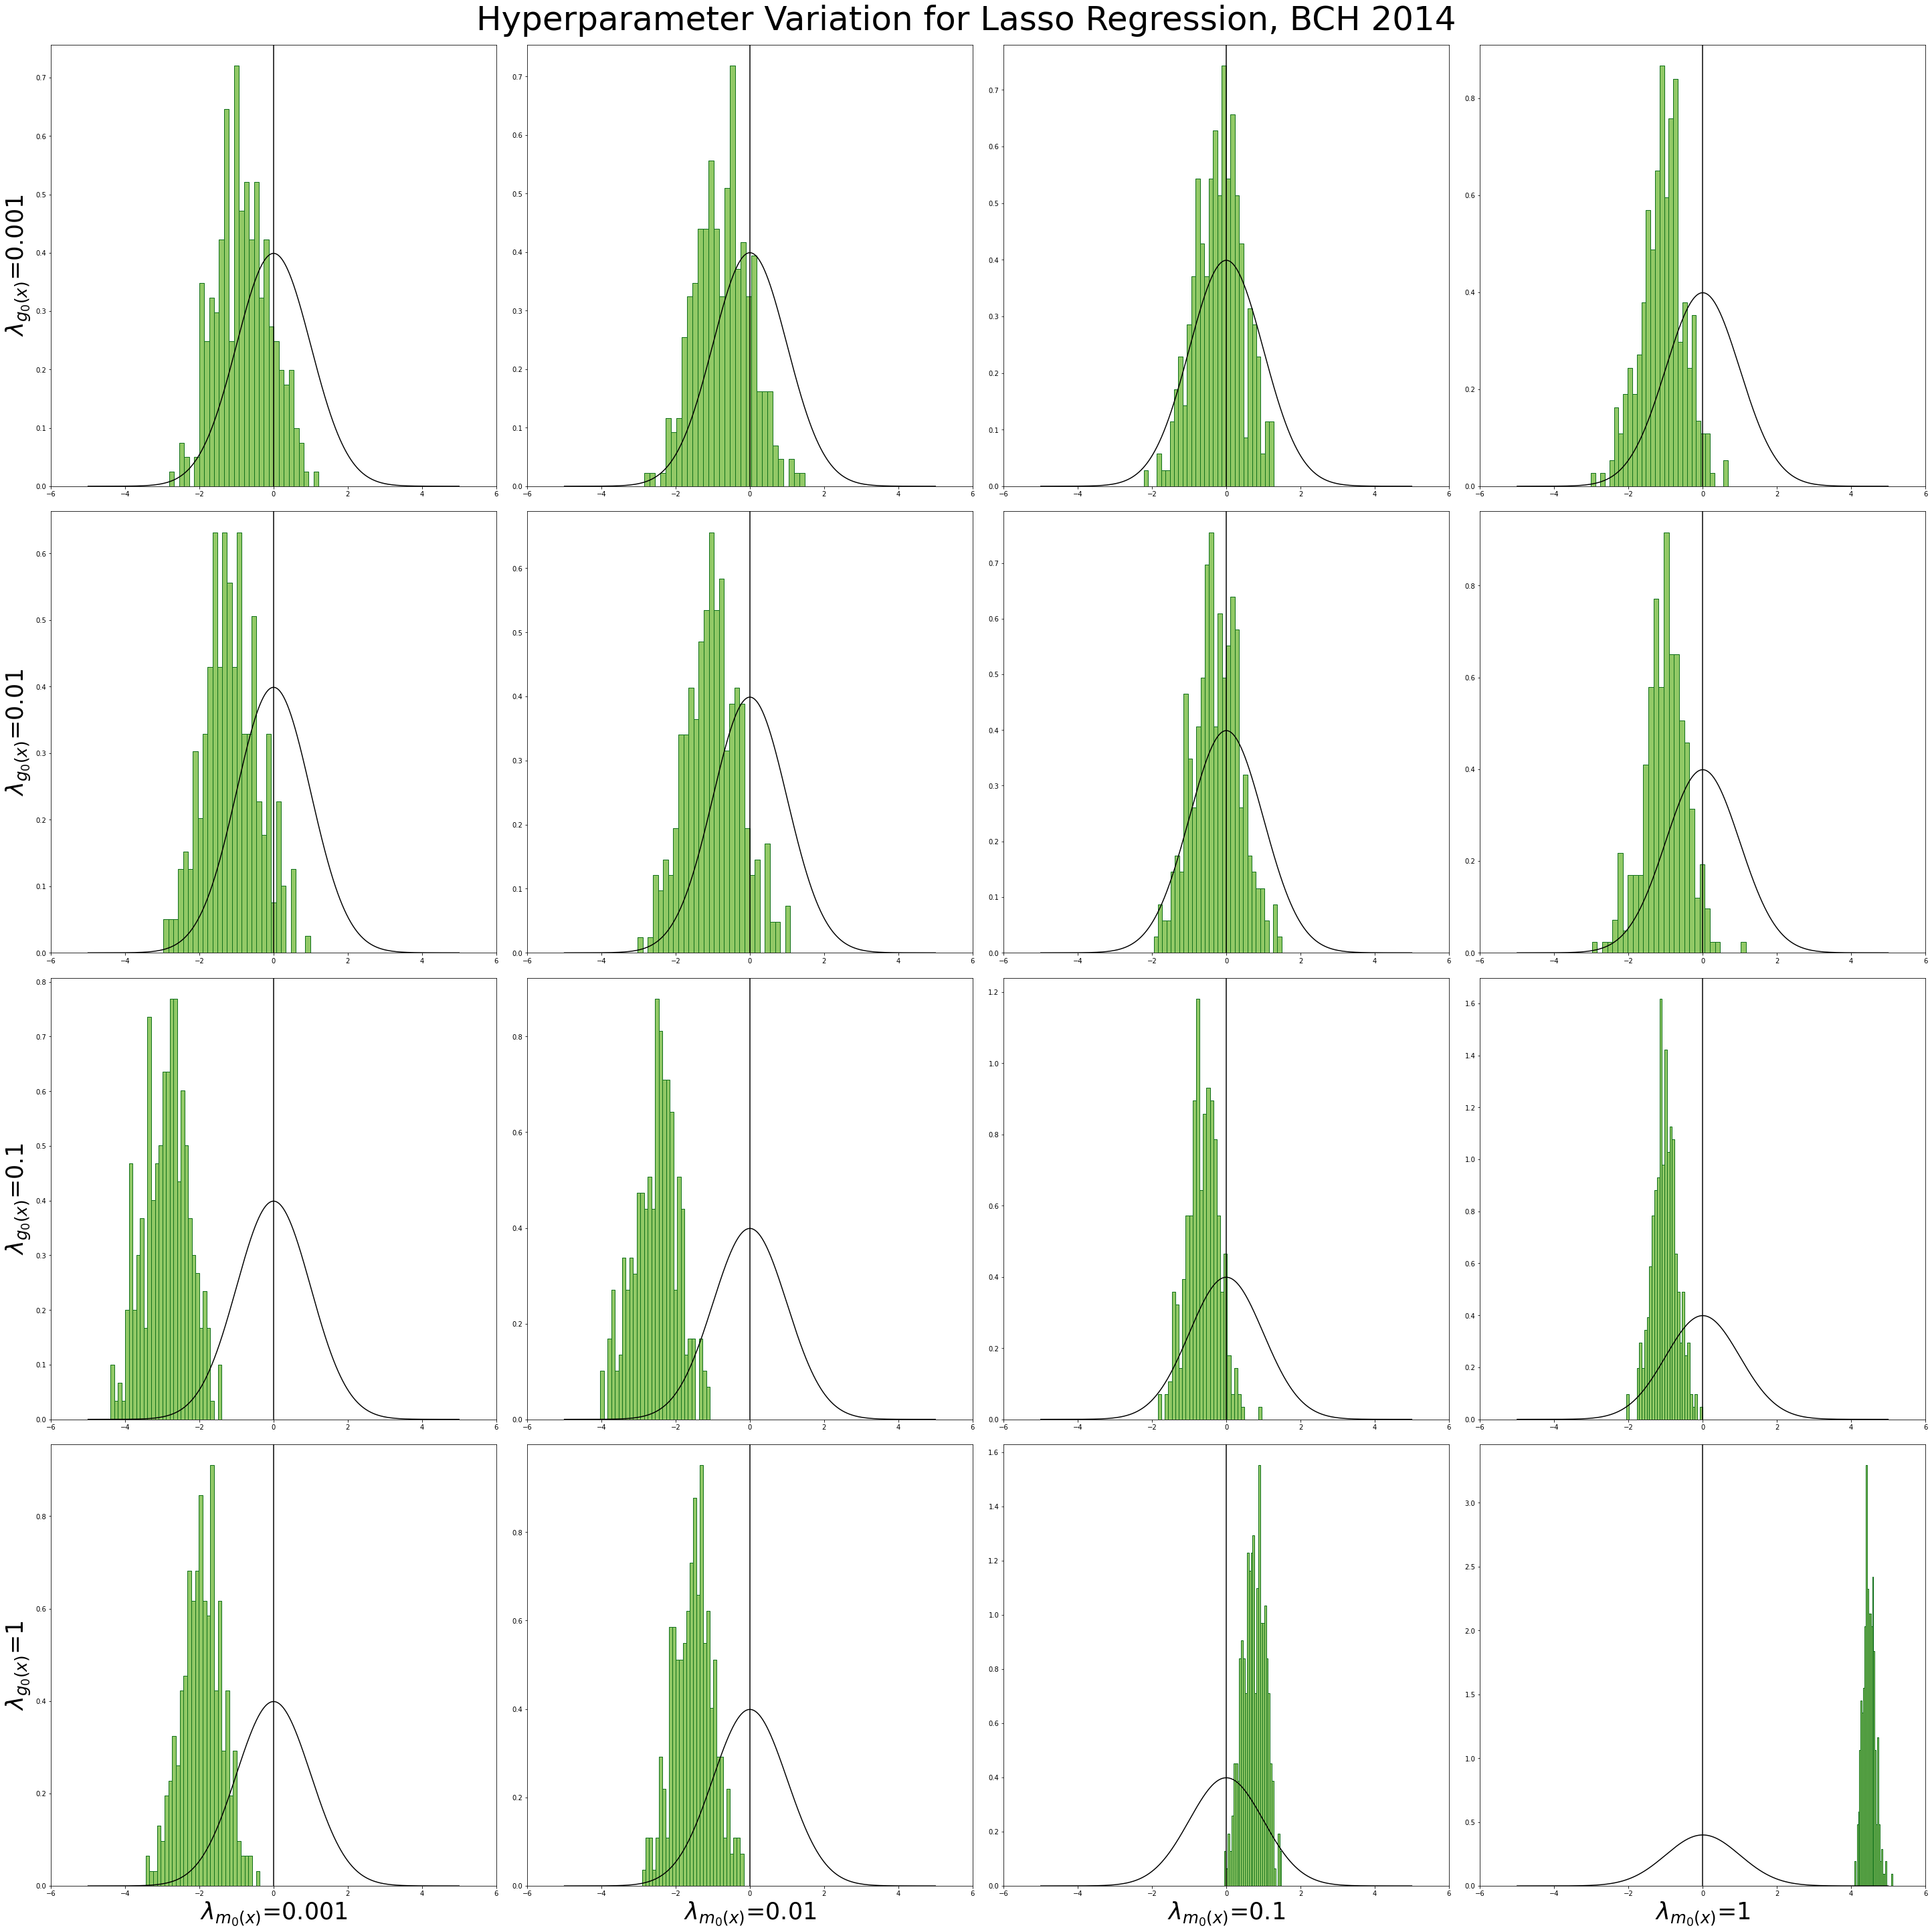

In [13]:
coverage_BCH14, bias_BCH14 = plot_lasso_variation_results(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l,
                                                          ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                                          n_folds=n_folds, data=data_BCH14, true_alpha=theta_BCH14,
                                                          title="Hyperparameter Variation for Lasso Regression, BCH 2014",
                                                          filename="lasso_hyperparameter_variation_BCH2014.png")

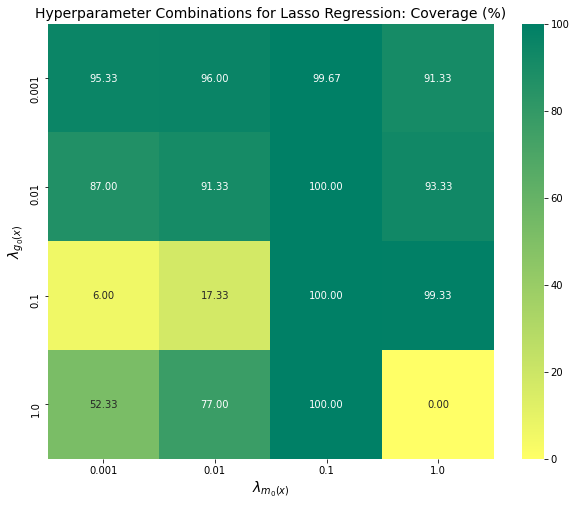

In [14]:
plot_lasso_coverage(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    coverage_scores=coverage_BCH14,
                    filename="lasso_hyperparameters_coverage_BCH2014.png")

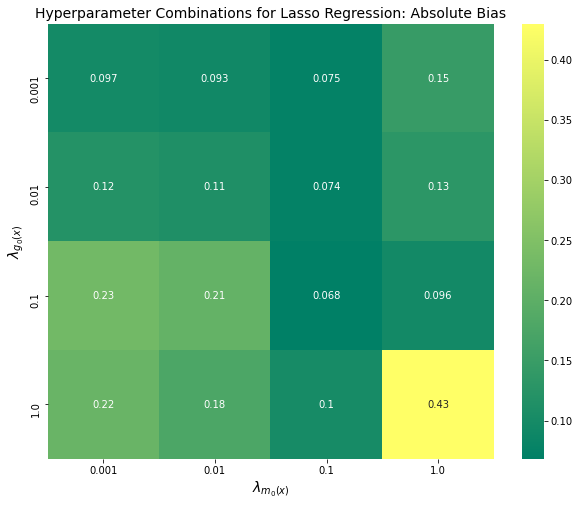

In [15]:
plot_lasso_abs_bias(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    bias_scores=bias_BCH14,
                    filename="lasso_hyperparameters_bias_BCH2014.png")

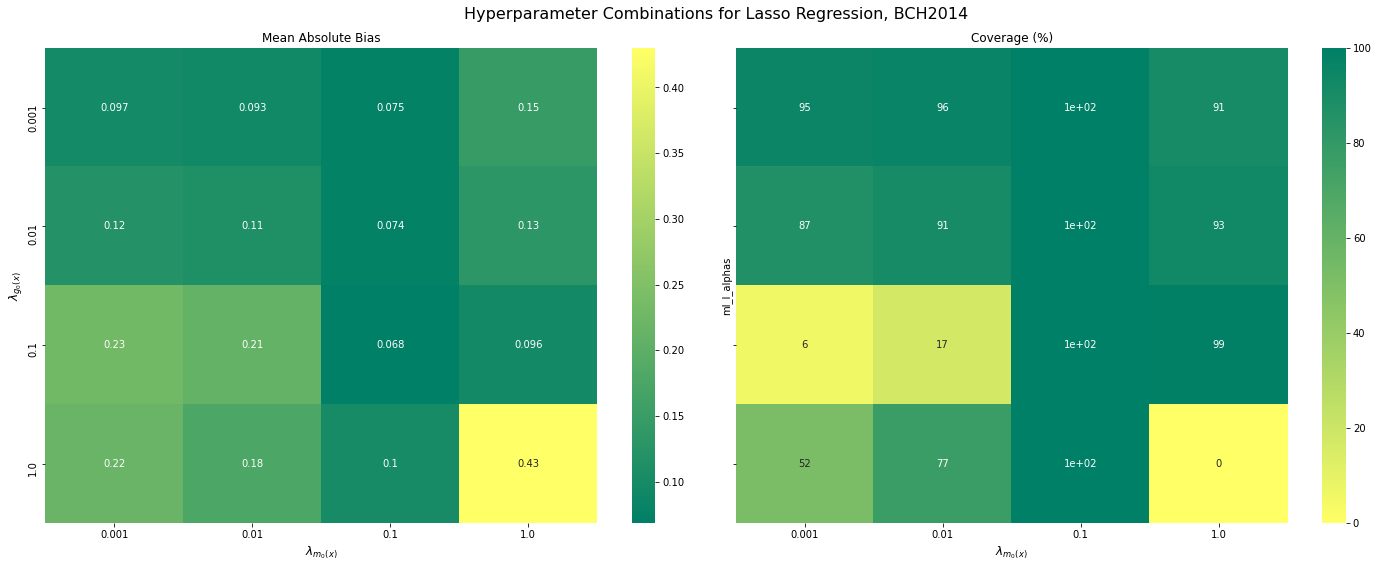

In [16]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                                     ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                     bias_scores=bias_BCH14,
                                     coverage_scores=coverage_BCH14,
                                     suptitle="Hyperparameter Combinations for Lasso Regression, BCH2014",
                                     filename="lasso_hyperparameters_bias_and_coverage_BCH2014.png")

# 3. Lasso Regression with Cross-Validation

## 2.1 DGB 1: CCDDHNR2018

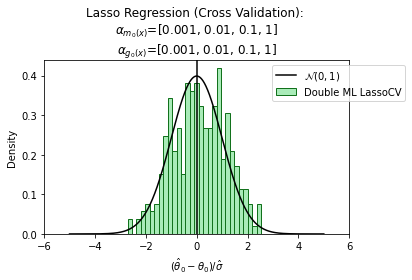

In [17]:
ml_l_cv = LassoCV(alphas=lasso_alpha_hyperparams_ml_l)
ml_m_cv = LassoCV(alphas=lasso_alpha_hyperparams_ml_m)

cv_thetas, cv_se, cv_plr_objects, \
cv_alphas = simulate_lasso_plr(ml_l=ml_l_cv, ml_m=ml_m_cv, n_folds=n_folds,
                                data=data, score='partialling out')
plot_lasso_score(ml_l=ml_l_cv, ml_m=ml_m_cv, theta_scores=cv_thetas, se_scores=cv_se, alpha=alpha)

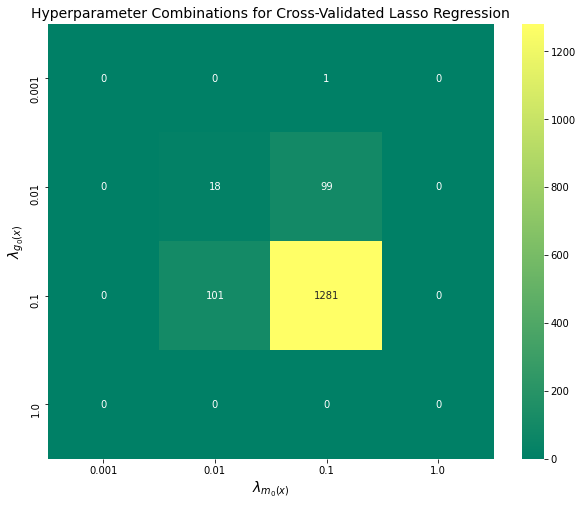

In [18]:
every_hyperparameter_combination = list(itertools.product(lasso_alpha_hyperparams_ml_l,
                                                        lasso_alpha_hyperparams_ml_m))

lasso_alphas_counts = {}

for comb in every_hyperparameter_combination:
    lasso_alphas_counts[comb] = 0

for occ in cv_alphas:
    lasso_alphas_counts[occ] += 1

counts_list = [(k[0], k[1], v) for k, v in lasso_alphas_counts.items()]
lasso_alphas_df = pd.DataFrame(counts_list, columns=['ml_l_alphas', 'ml_m_alphas', 'count'])
pivot_table = lasso_alphas_df.pivot(index='ml_l_alphas', columns='ml_m_alphas', values='count')

plt.figure(figsize=(2.5*len(lasso_alpha_hyperparams_ml_l), 2*len(lasso_alpha_hyperparams_ml_m)))
plt.title("Hyperparameter Combinations for Cross-Validated Lasso Regression", fontsize=14)
sns.heatmap(pivot_table, cmap='summer', annot=True, fmt=".0f")
plt.xlabel('$\\lambda_{m_{0}(x)}$', fontsize=14)
plt.ylabel('$\\lambda_{g_{0}(x)}$', fontsize=14)
plt.savefig("plots/cross_validated_lasso_hyperparameters.png", facecolor="white")
plt.show()

## 3.2 DGB 2: BCH2014

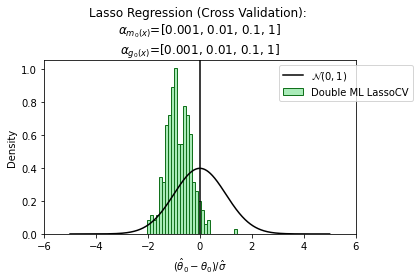

In [19]:
ml_l_cv_BCH = LassoCV(alphas=lasso_alpha_hyperparams_ml_l)
ml_m_cv_BCH = LassoCV(alphas=lasso_alpha_hyperparams_ml_m)

cv_thetas_BCH, cv_se_BCH, cv_plr_objects_BCH, \
cv_alphas_BCH = simulate_lasso_plr(ml_l=ml_l_cv_BCH, ml_m=ml_m_cv_BCH, n_folds=n_folds,
                                data=data_BCH14, score='partialling out')
plot_lasso_score(ml_l=ml_l_cv_BCH, ml_m=ml_m_cv_BCH, theta_scores=cv_thetas_BCH, se_scores=cv_se_BCH, alpha=alpha)

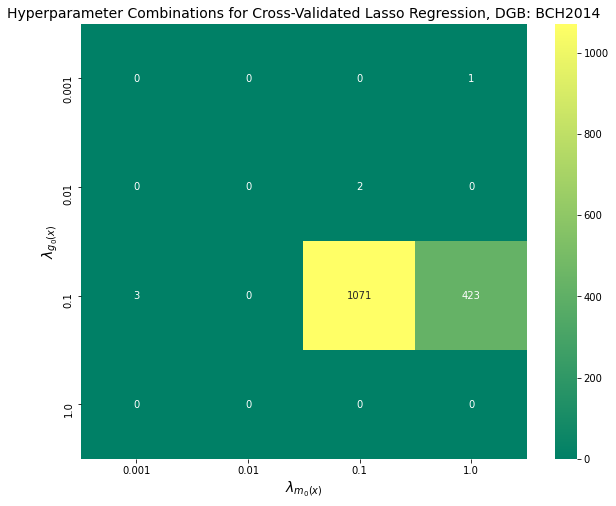

In [20]:
every_hyperparameter_combination = list(itertools.product(lasso_alpha_hyperparams_ml_l,
                                                        lasso_alpha_hyperparams_ml_m))

lasso_alphas_counts_BCH = {}

for comb in every_hyperparameter_combination:
    lasso_alphas_counts_BCH[comb] = 0

for occ in cv_alphas_BCH:
    lasso_alphas_counts_BCH[occ] += 1

counts_list_BCH = [(k[0], k[1], v) for k, v in lasso_alphas_counts_BCH.items()]
lasso_alphas_df_BCH = pd.DataFrame(counts_list_BCH, columns=['ml_l_alphas', 'ml_m_alphas', 'count'])
pivot_table_BCH = lasso_alphas_df_BCH.pivot(index='ml_l_alphas', columns='ml_m_alphas', values='count')

plt.figure(figsize=(2.5*len(lasso_alpha_hyperparams_ml_l), 2*len(lasso_alpha_hyperparams_ml_m)))
plt.title("Hyperparameter Combinations for Cross-Validated Lasso Regression, DGB: BCH2014", fontsize=14)
sns.heatmap(pivot_table_BCH, cmap='summer', annot=True, fmt=".0f")
plt.xlabel('$\\lambda_{m_{0}(x)}$', fontsize=14)
plt.ylabel('$\\lambda_{g_{0}(x)}$', fontsize=14)
plt.savefig("plots/cross_validated_lasso_hyperparameters_BCH2014.png", facecolor="white")
plt.show()

# 4. Delimited Hyperparameter Search Area

In [21]:
lasso_alpha_hyperparams_ml_m_delimited = list(np.arange(0.08, 0.12, 0.01))
lasso_alpha_hyperparams_ml_l_delimited = list(np.arange(0.08, 0.12, 0.01))

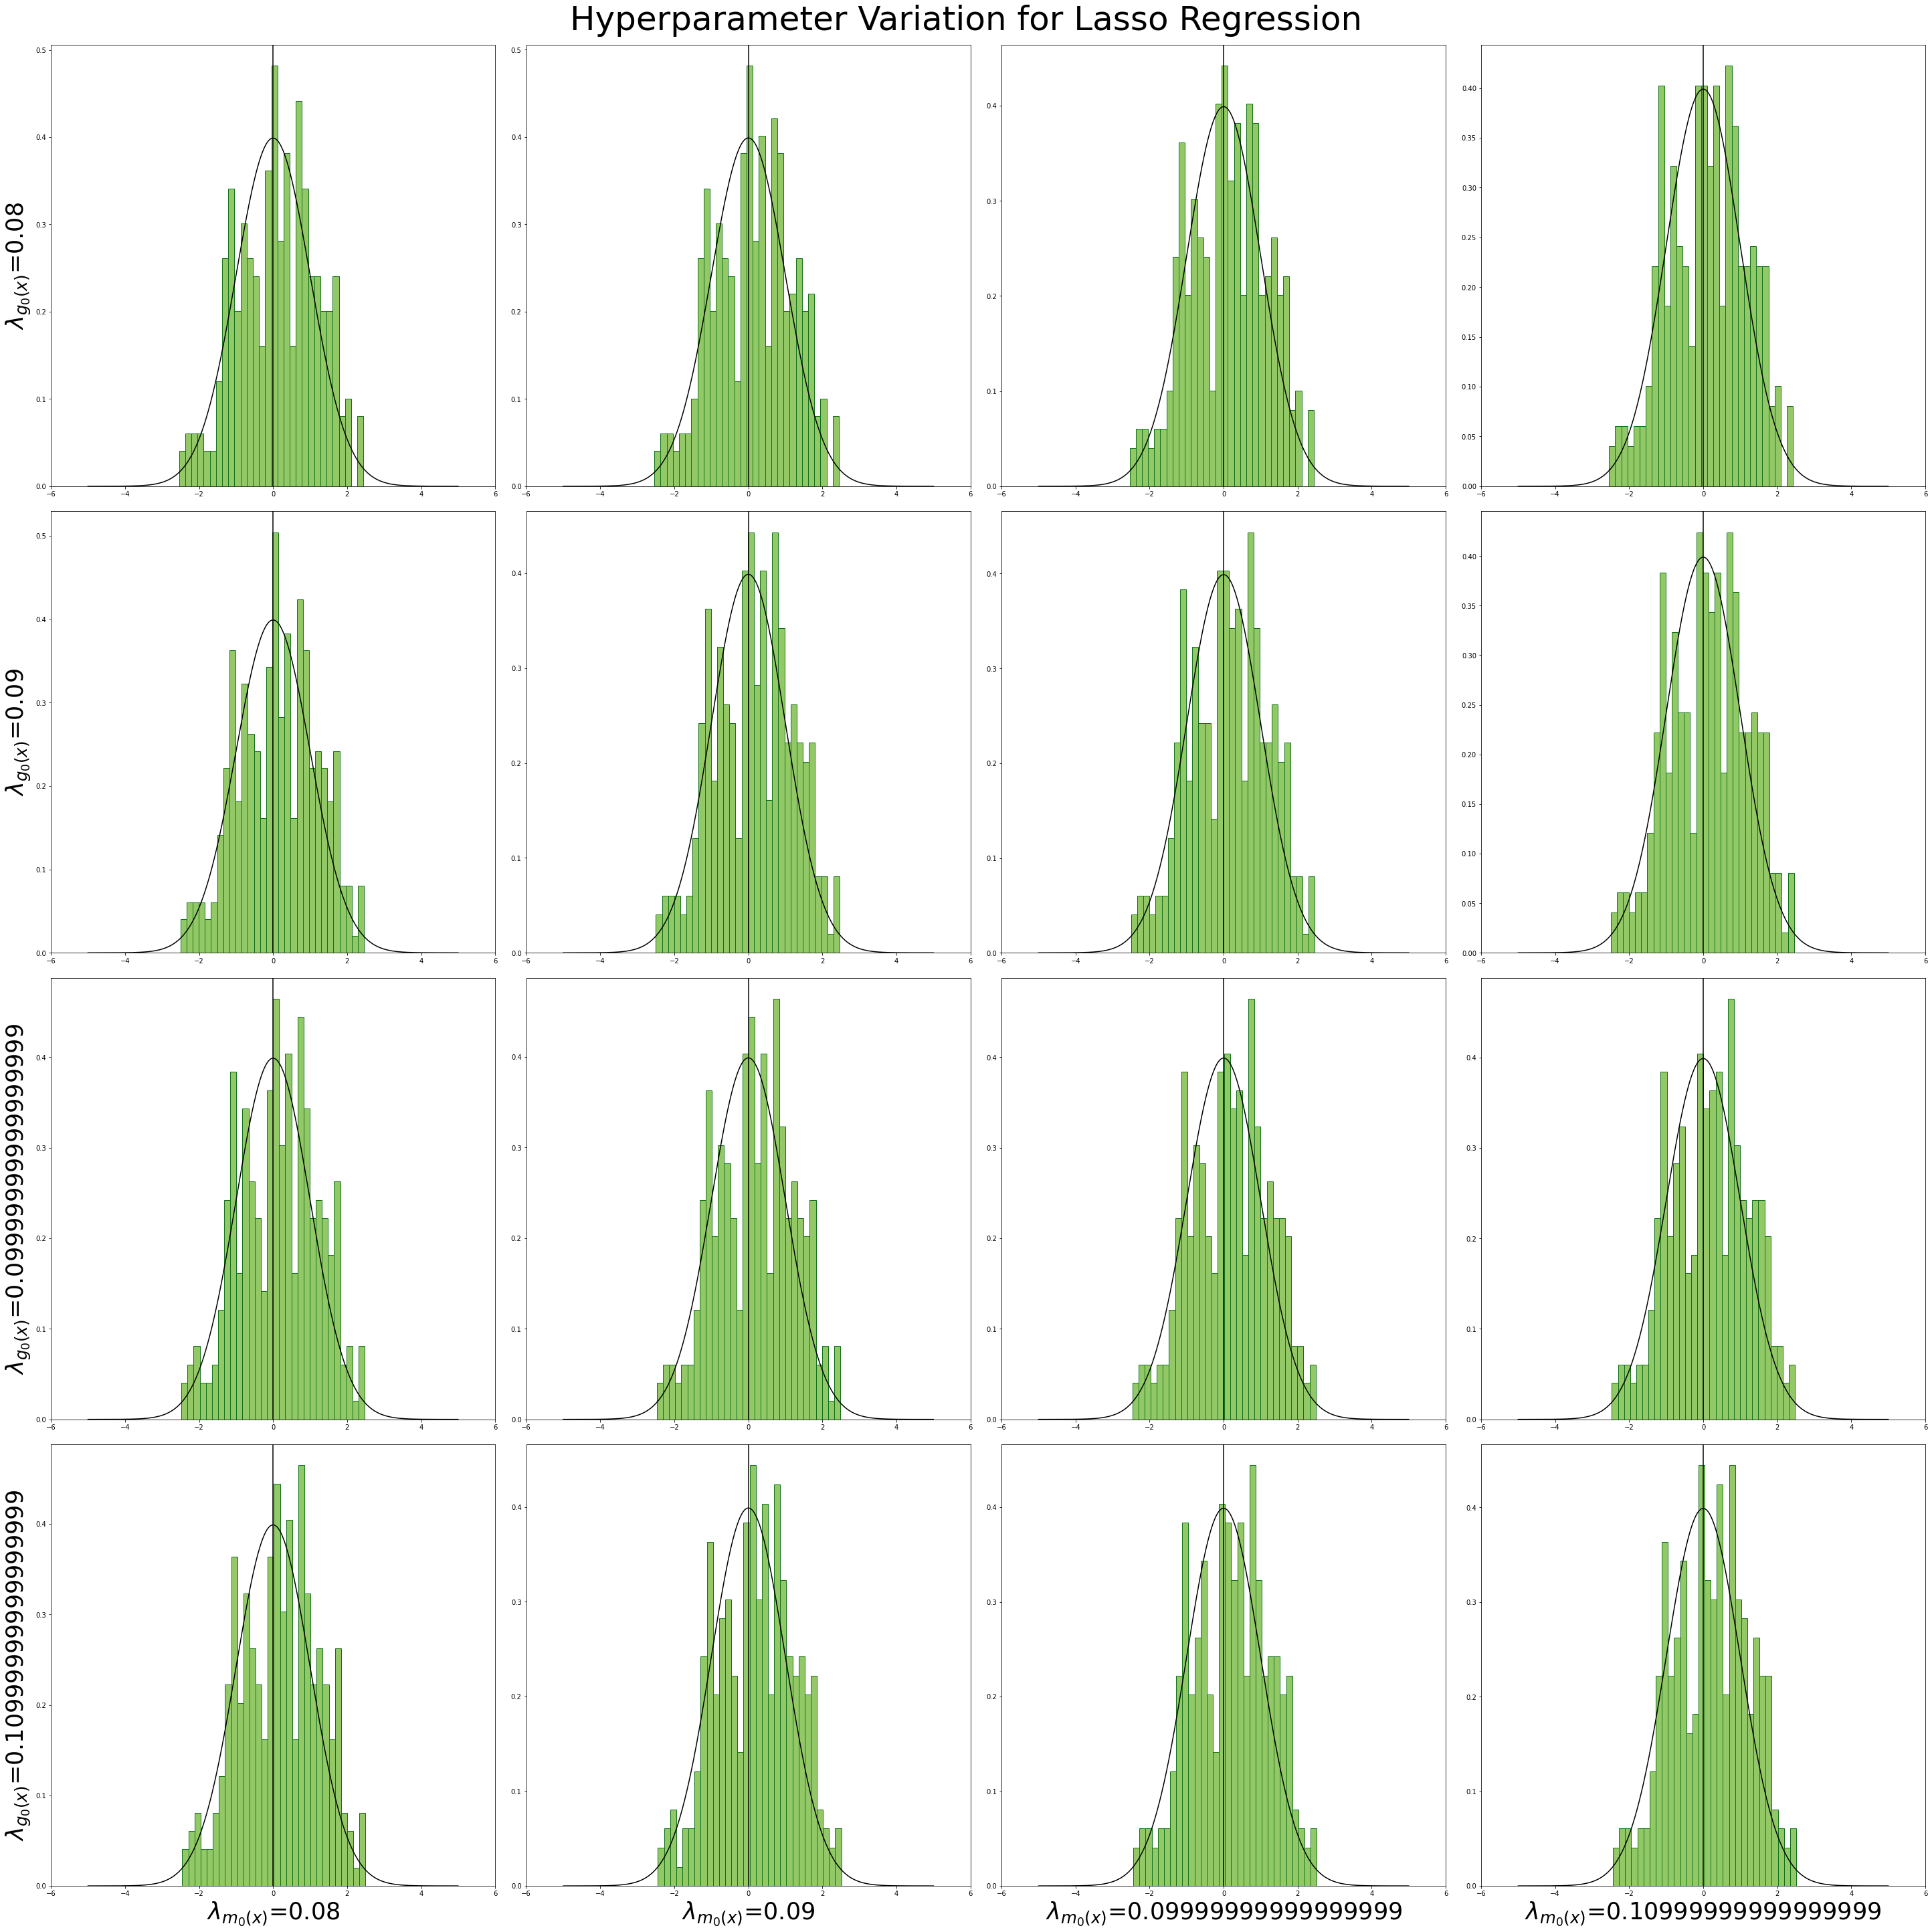

In [22]:
coverage_delimited, bias_delimited = plot_lasso_variation_results(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l_delimited,
                                                                  ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m_delimited,
                                                                  n_folds=n_folds, data=data, true_alpha=alpha,
                                                                  title="Hyperparameter Variation for Lasso Regression",
                                                                  filename="lasso_hyperparameter_variation_delimited.png")

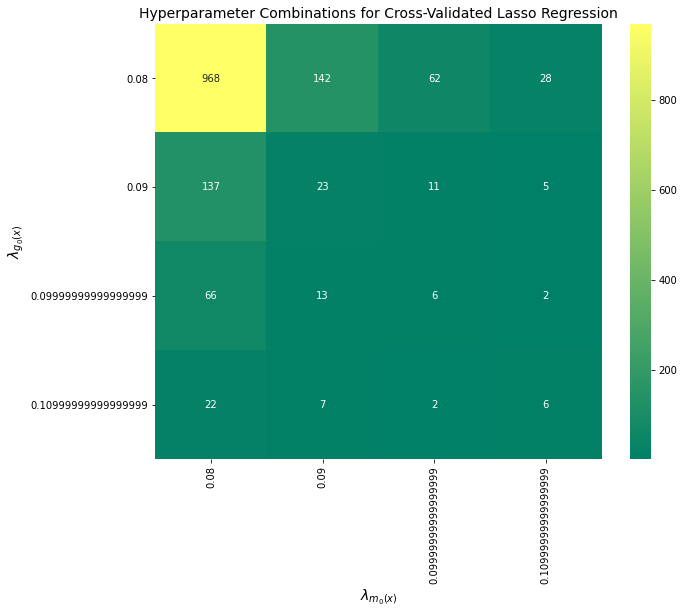

In [23]:
ml_l_cv_delimited = LassoCV(alphas=lasso_alpha_hyperparams_ml_l_delimited)
ml_m_cv_delimited = LassoCV(alphas=lasso_alpha_hyperparams_ml_m_delimited)

cv_thetas_delimited, cv_se_delimited, cv_plrobjects_delimited, cv_alphas_delimited = simulate_lasso_plr(ml_l=ml_l_cv_delimited, 
                                                                           ml_m=ml_m_cv_delimited, 
                                                                           n_folds=n_folds,
                                                                           data=data, score='partialling out')

every_hyperparameter_combination = list(itertools.product(lasso_alpha_hyperparams_ml_l_delimited,
                                                        lasso_alpha_hyperparams_ml_m_delimited))

lasso_alphas_counts = {}

for comb in every_hyperparameter_combination:
    lasso_alphas_counts[comb] = 0

for occ in cv_alphas_delimited:
    lasso_alphas_counts[occ] += 1

counts_list = [(k[0], k[1], v) for k, v in lasso_alphas_counts.items()]
lasso_alphas_df = pd.DataFrame(counts_list, columns=['ml_l_alphas', 'ml_m_alphas', 'count'])
pivot_table = lasso_alphas_df.pivot(index='ml_l_alphas', columns='ml_m_alphas', values='count')

plt.figure(figsize=(2.5*len(lasso_alpha_hyperparams_ml_l_delimited), 
                    2*len(lasso_alpha_hyperparams_ml_m_delimited)))
plt.title("Hyperparameter Combinations for Cross-Validated Lasso Regression", fontsize=14)
sns.heatmap(pivot_table, cmap='summer', annot=True, fmt=".0f")
plt.xlabel('$\\lambda_{m_{0}(x)}$', fontsize=14)
plt.ylabel('$\\lambda_{g_{0}(x)}$', fontsize=14)
plt.savefig("plots/cross_validated_lasso_hyperparameters_delimited.png", facecolor="white")
plt.show()

# 5. BCH2014: n and p Variation

## 5.1 "Tall Data": Big n, Small p 

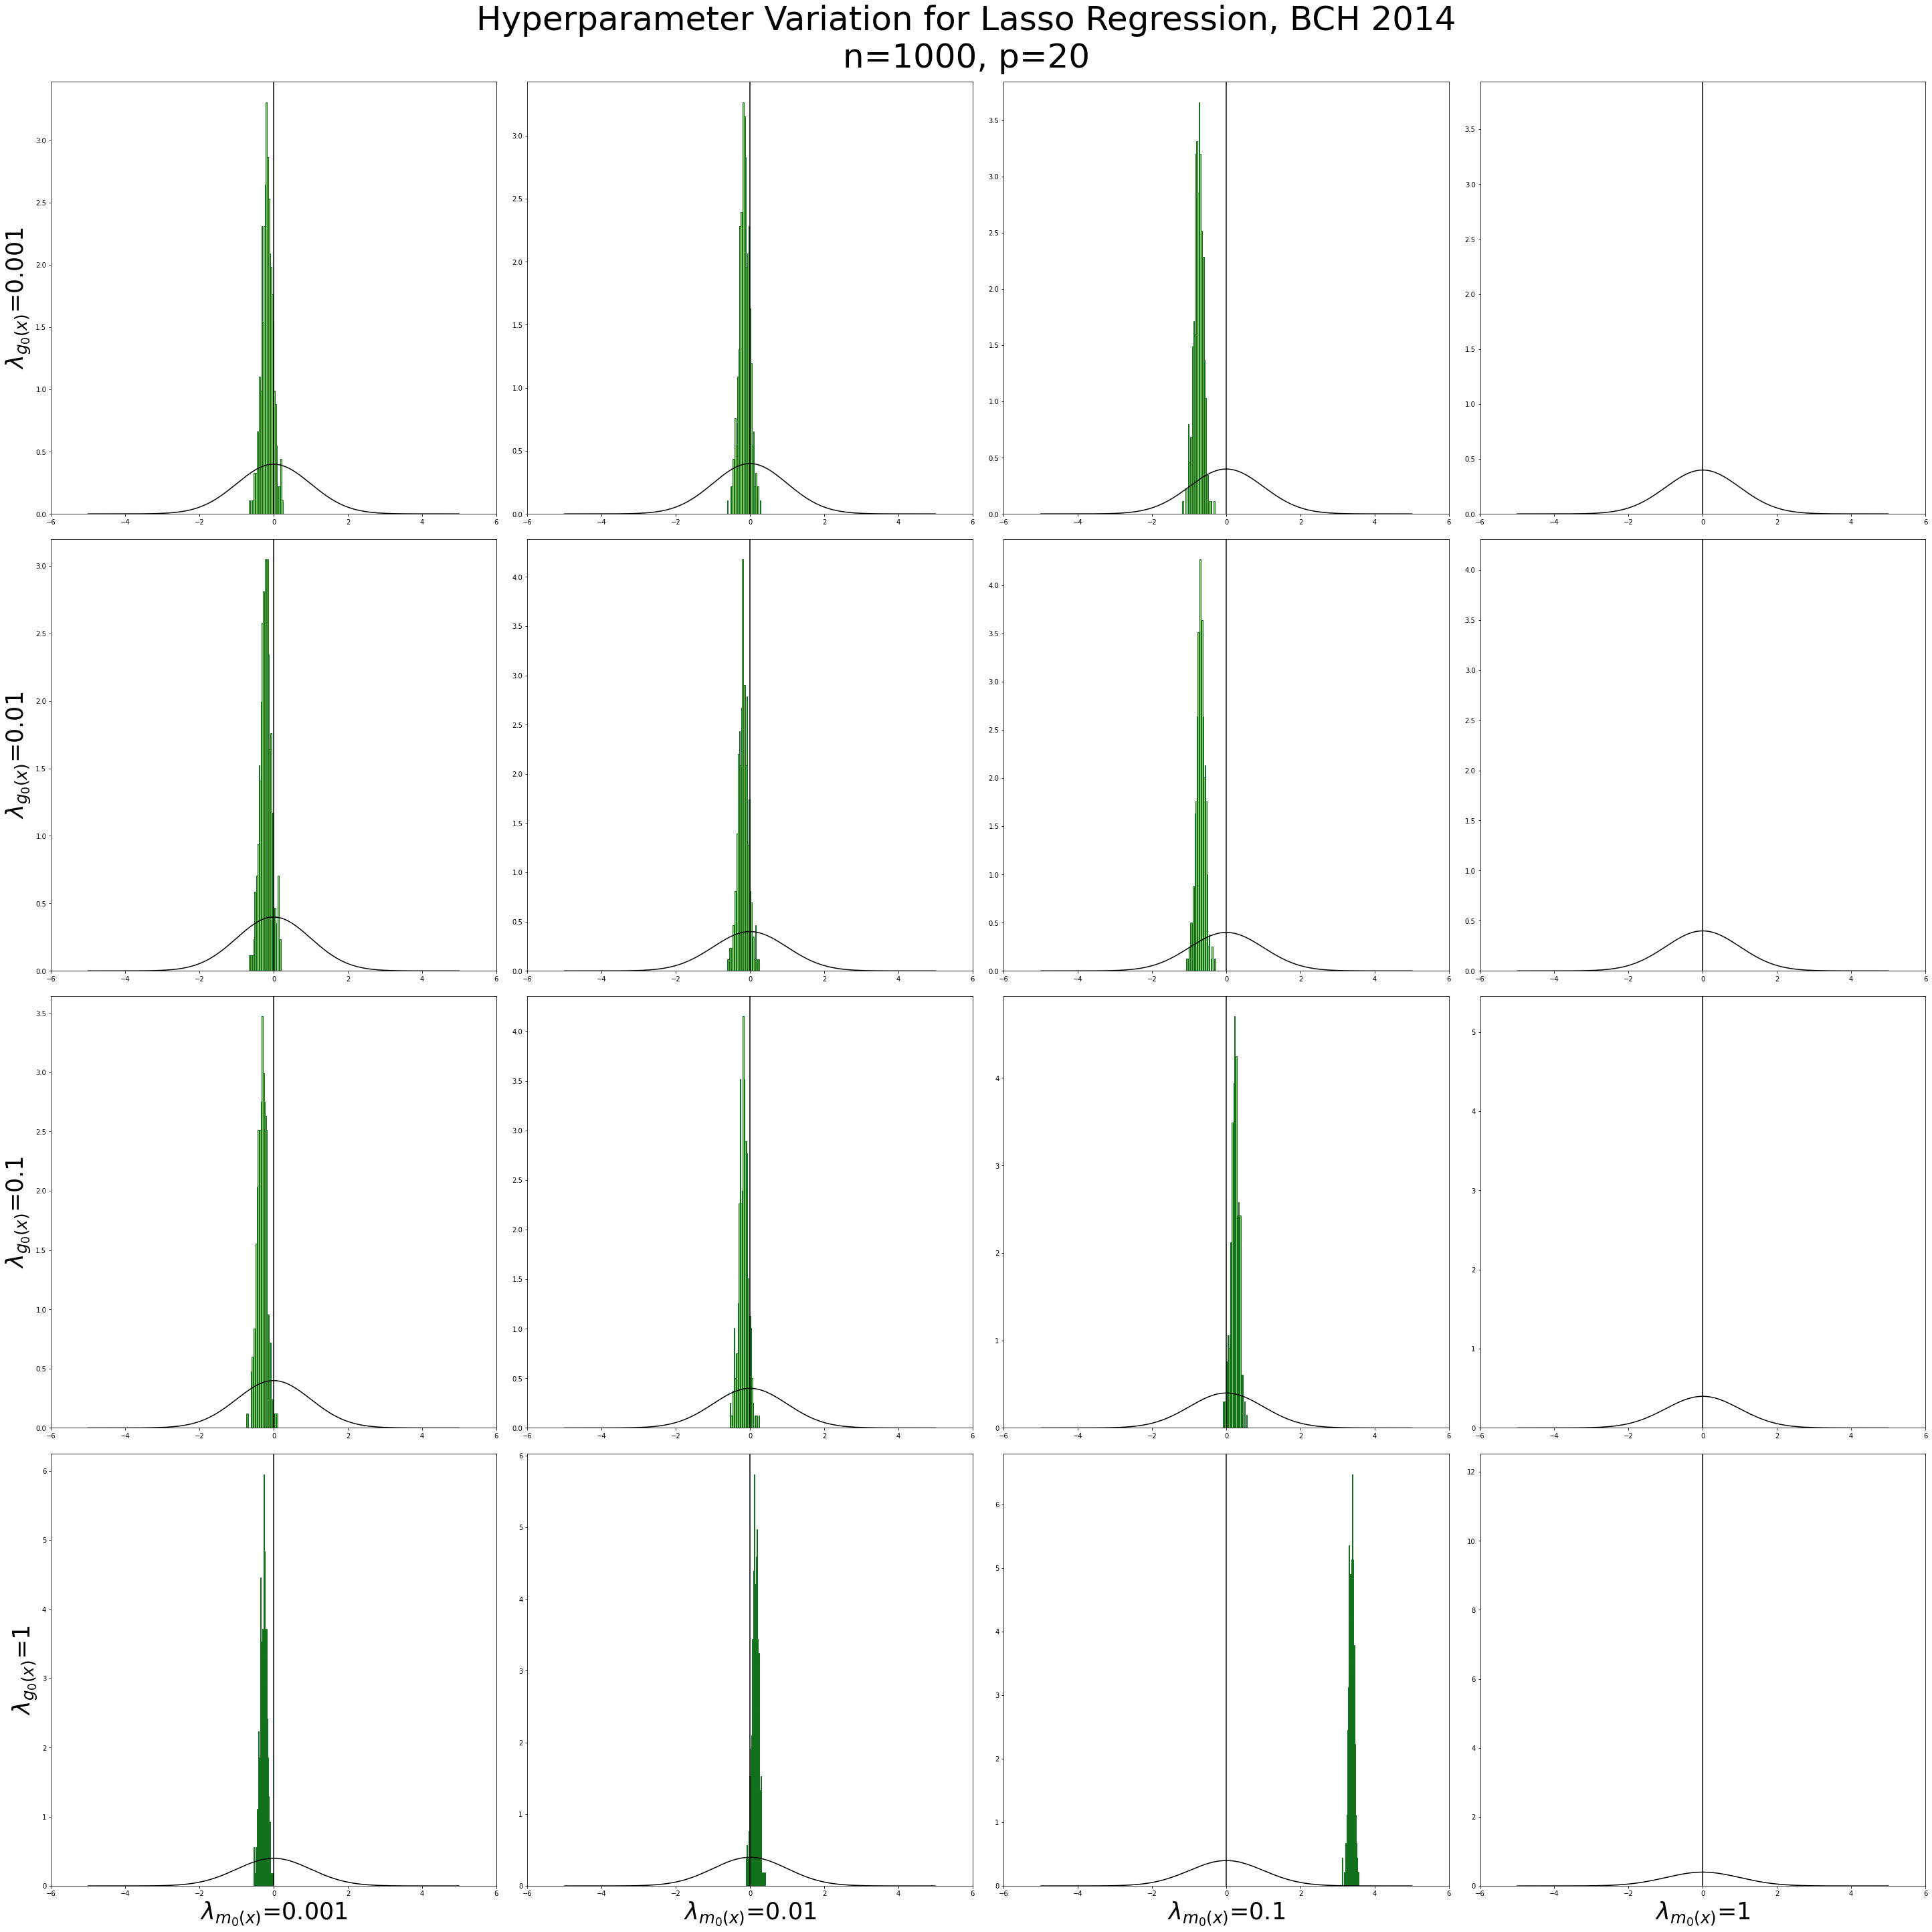

In [24]:
n_obs_tall = 1000
dim_x_tall = 20

data_BCH14_tall = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_tall, dim_x=dim_x_tall,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

coverage_BCH14_tall, bias_BCH14_tall = plot_lasso_variation_results(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l,
                                                                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                                                    n_folds=n_folds, data=data_BCH14_tall, true_alpha=theta_BCH14,
                                                                    title=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_tall}, p={dim_x_tall}",
                                                                    filename="lasso_hyperparameter_variation_BCH2014_tall_data.png")

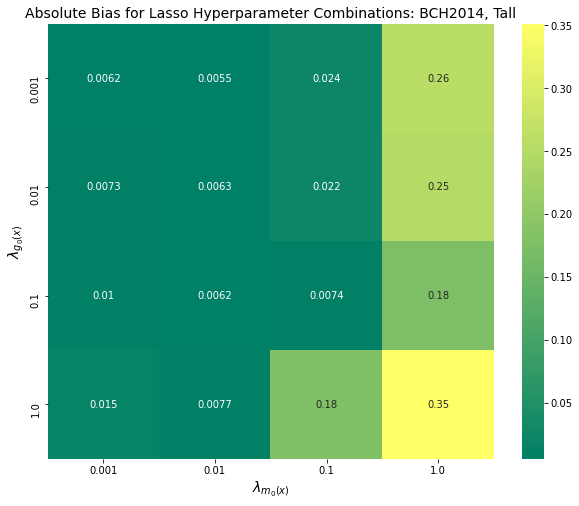

In [25]:
plot_lasso_abs_bias(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    bias_scores=bias_BCH14_tall,
                    title="Absolute Bias for Lasso Hyperparameter Combinations: BCH2014, Tall",
                    filename="lasso_hyperparameters_bias_BCH2014_tall.png")

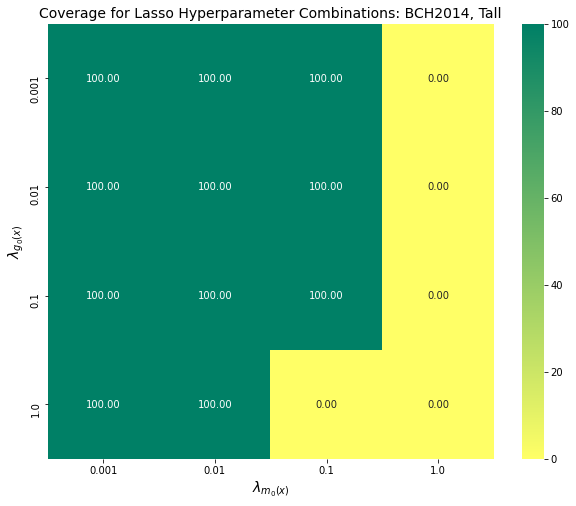

In [26]:
plot_lasso_coverage(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    coverage_scores=coverage_BCH14_tall,
                    title="Coverage for Lasso Hyperparameter Combinations: BCH2014, Tall",
                    filename="lasso_hyperparameters_coverage_BCH2014_tall.png")

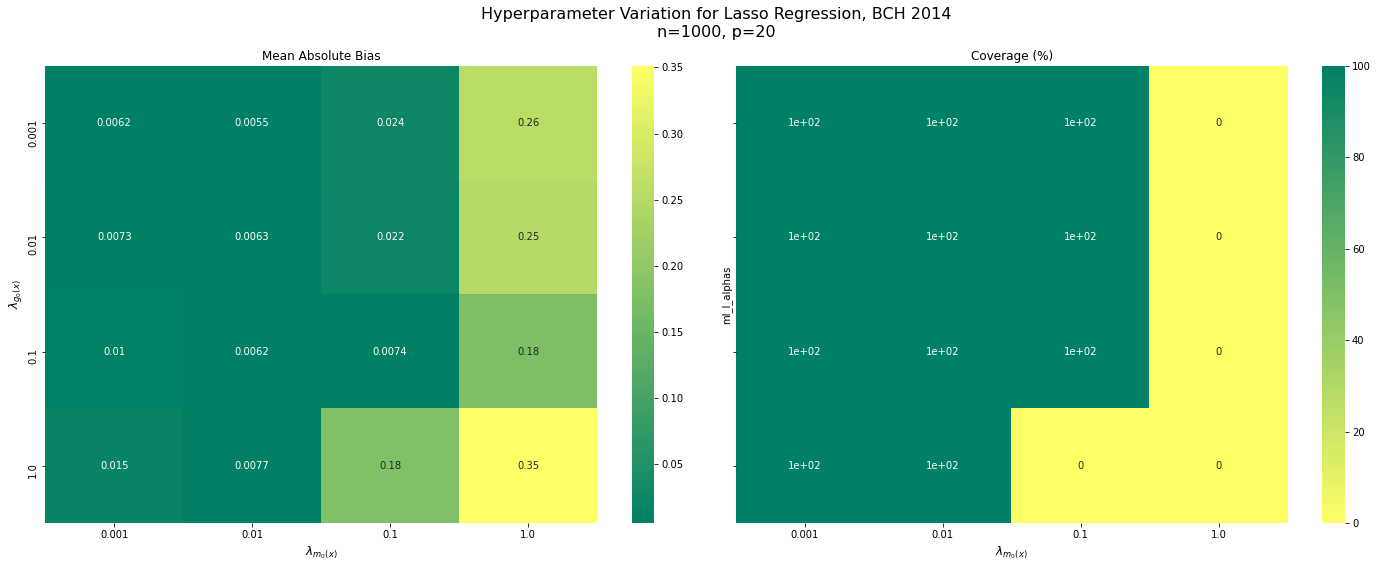

In [27]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                                     ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                     bias_scores=bias_BCH14_tall,
                                     coverage_scores=coverage_BCH14_tall,
                                     suptitle=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_tall}, p={dim_x_tall}",
                                     filename="lasso_hyperparameters_bias_coverage_BCH2014_tall.png")

## 5.2 "Wide Data": Small n, Big p

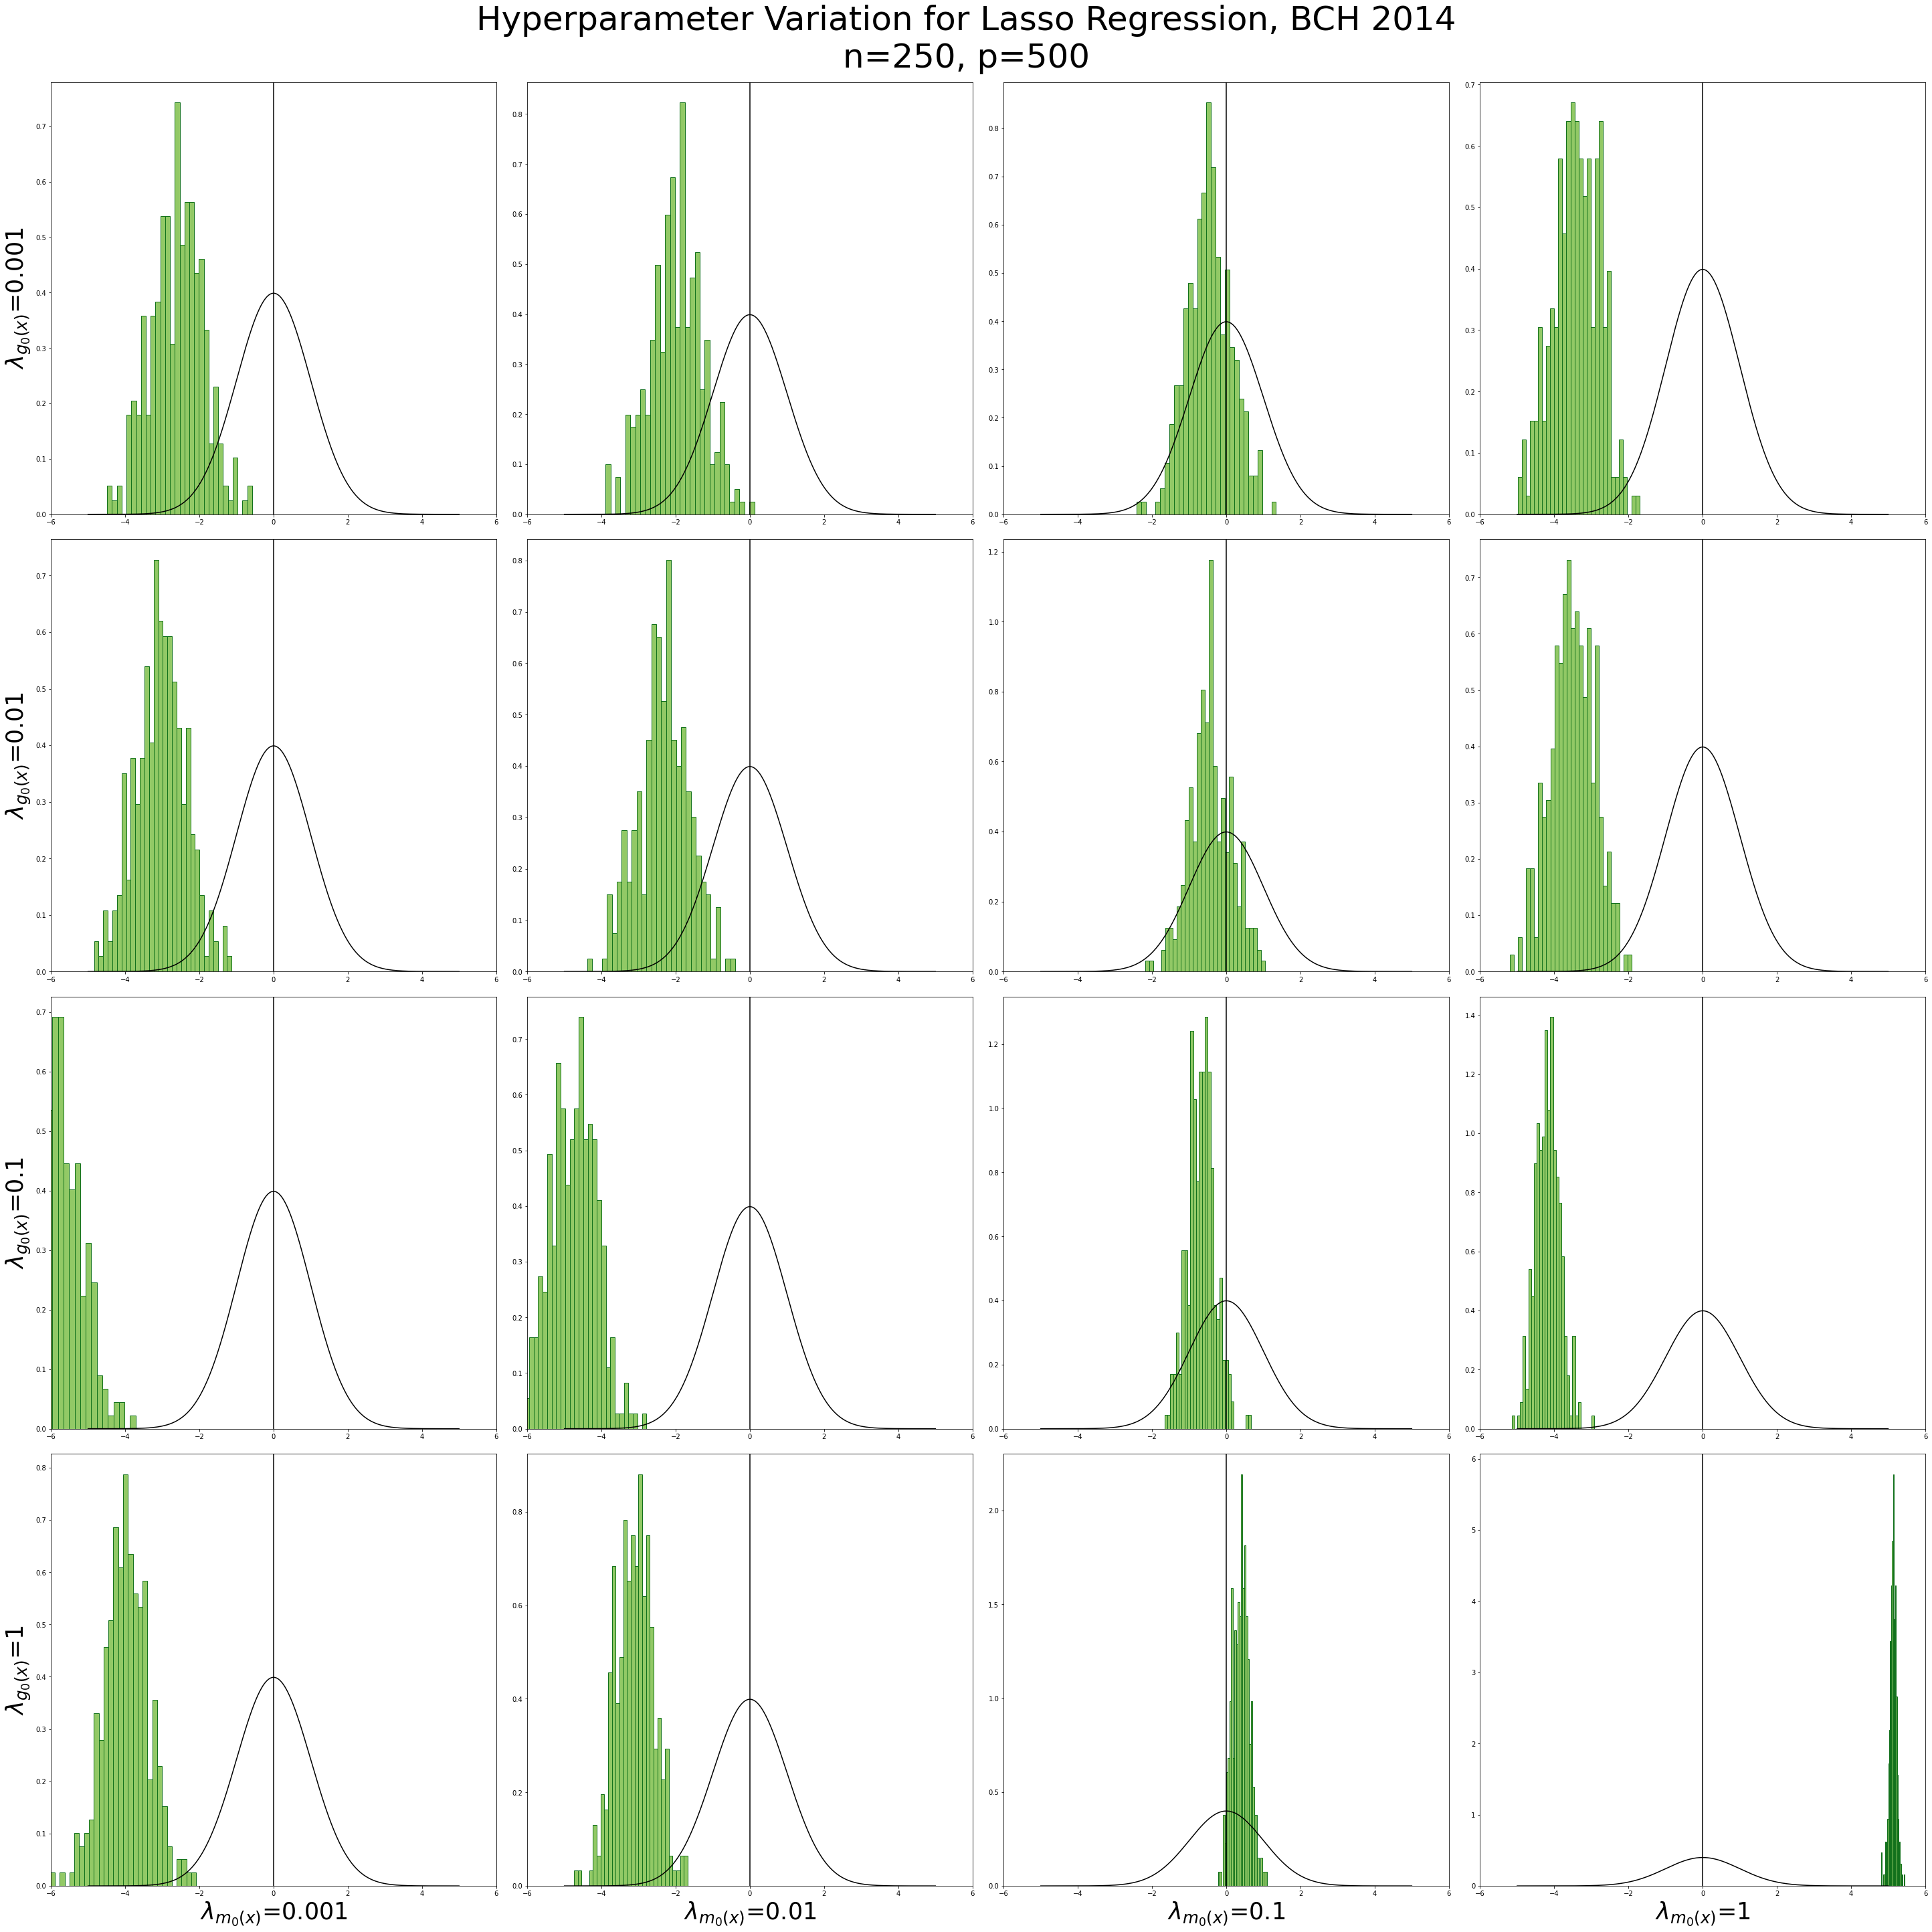

In [5]:
n_obs_wide = 250
dim_x_wide = 500

data_BCH14_wide = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_wide, dim_x=dim_x_wide,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

coverage_BCH14_wide, bias_BCH14_wide = plot_lasso_variation_results(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l,
                                                                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                                                    n_folds=n_folds, data=data_BCH14_wide, true_alpha=theta_BCH14,
                                                                    title=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_wide}, p={dim_x_wide}",
                                                                    filename="lasso_hyperparameter_variation_BCH2014_wide_data.png")

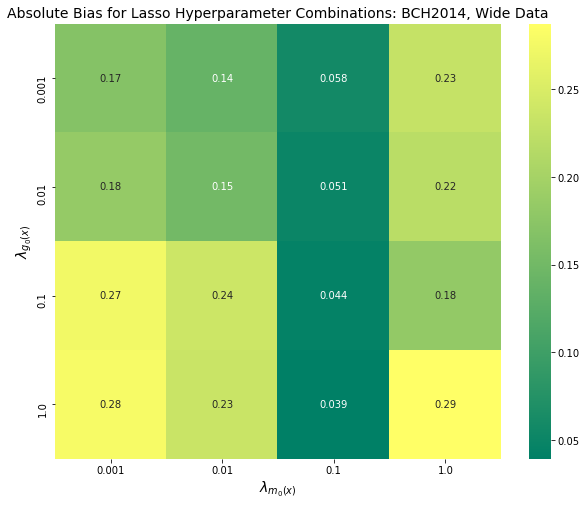

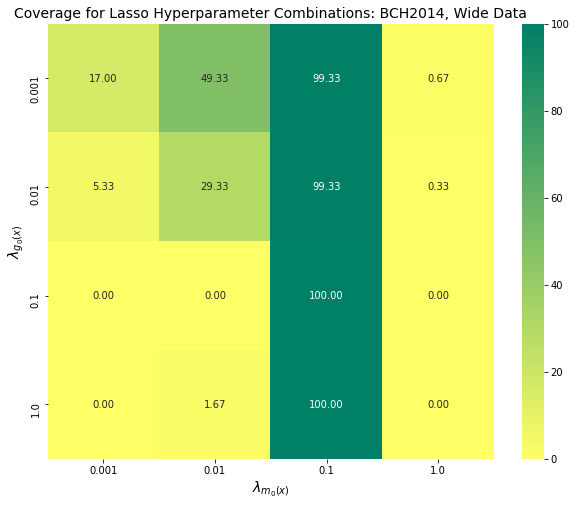

In [29]:
plot_lasso_abs_bias(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    bias_scores=bias_BCH14_wide,
                    title="Absolute Bias for Lasso Hyperparameter Combinations: BCH2014, Wide Data",
                    filename="lasso_hyperparameters_bias_BCH2014_wide.png")

plot_lasso_coverage(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    coverage_scores=coverage_BCH14_wide,
                    title="Coverage for Lasso Hyperparameter Combinations: BCH2014, Wide Data",
                    filename="lasso_hyperparameters_coverage_BCH2014_wide.png")

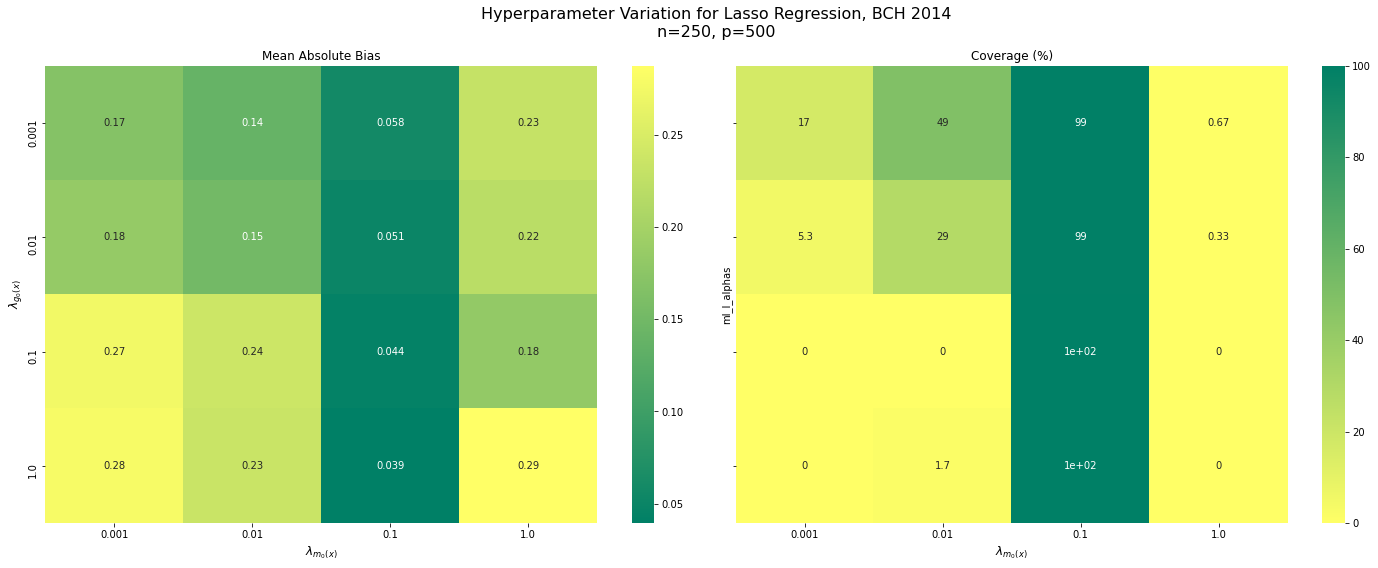

In [30]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                                     ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                     bias_scores=bias_BCH14_wide,
                                     coverage_scores=coverage_BCH14_wide,
                                     suptitle=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_wide}, p={dim_x_wide}",
                                     filename="lasso_hyperparameters_bias_coverage_BCH2014_wide.png")

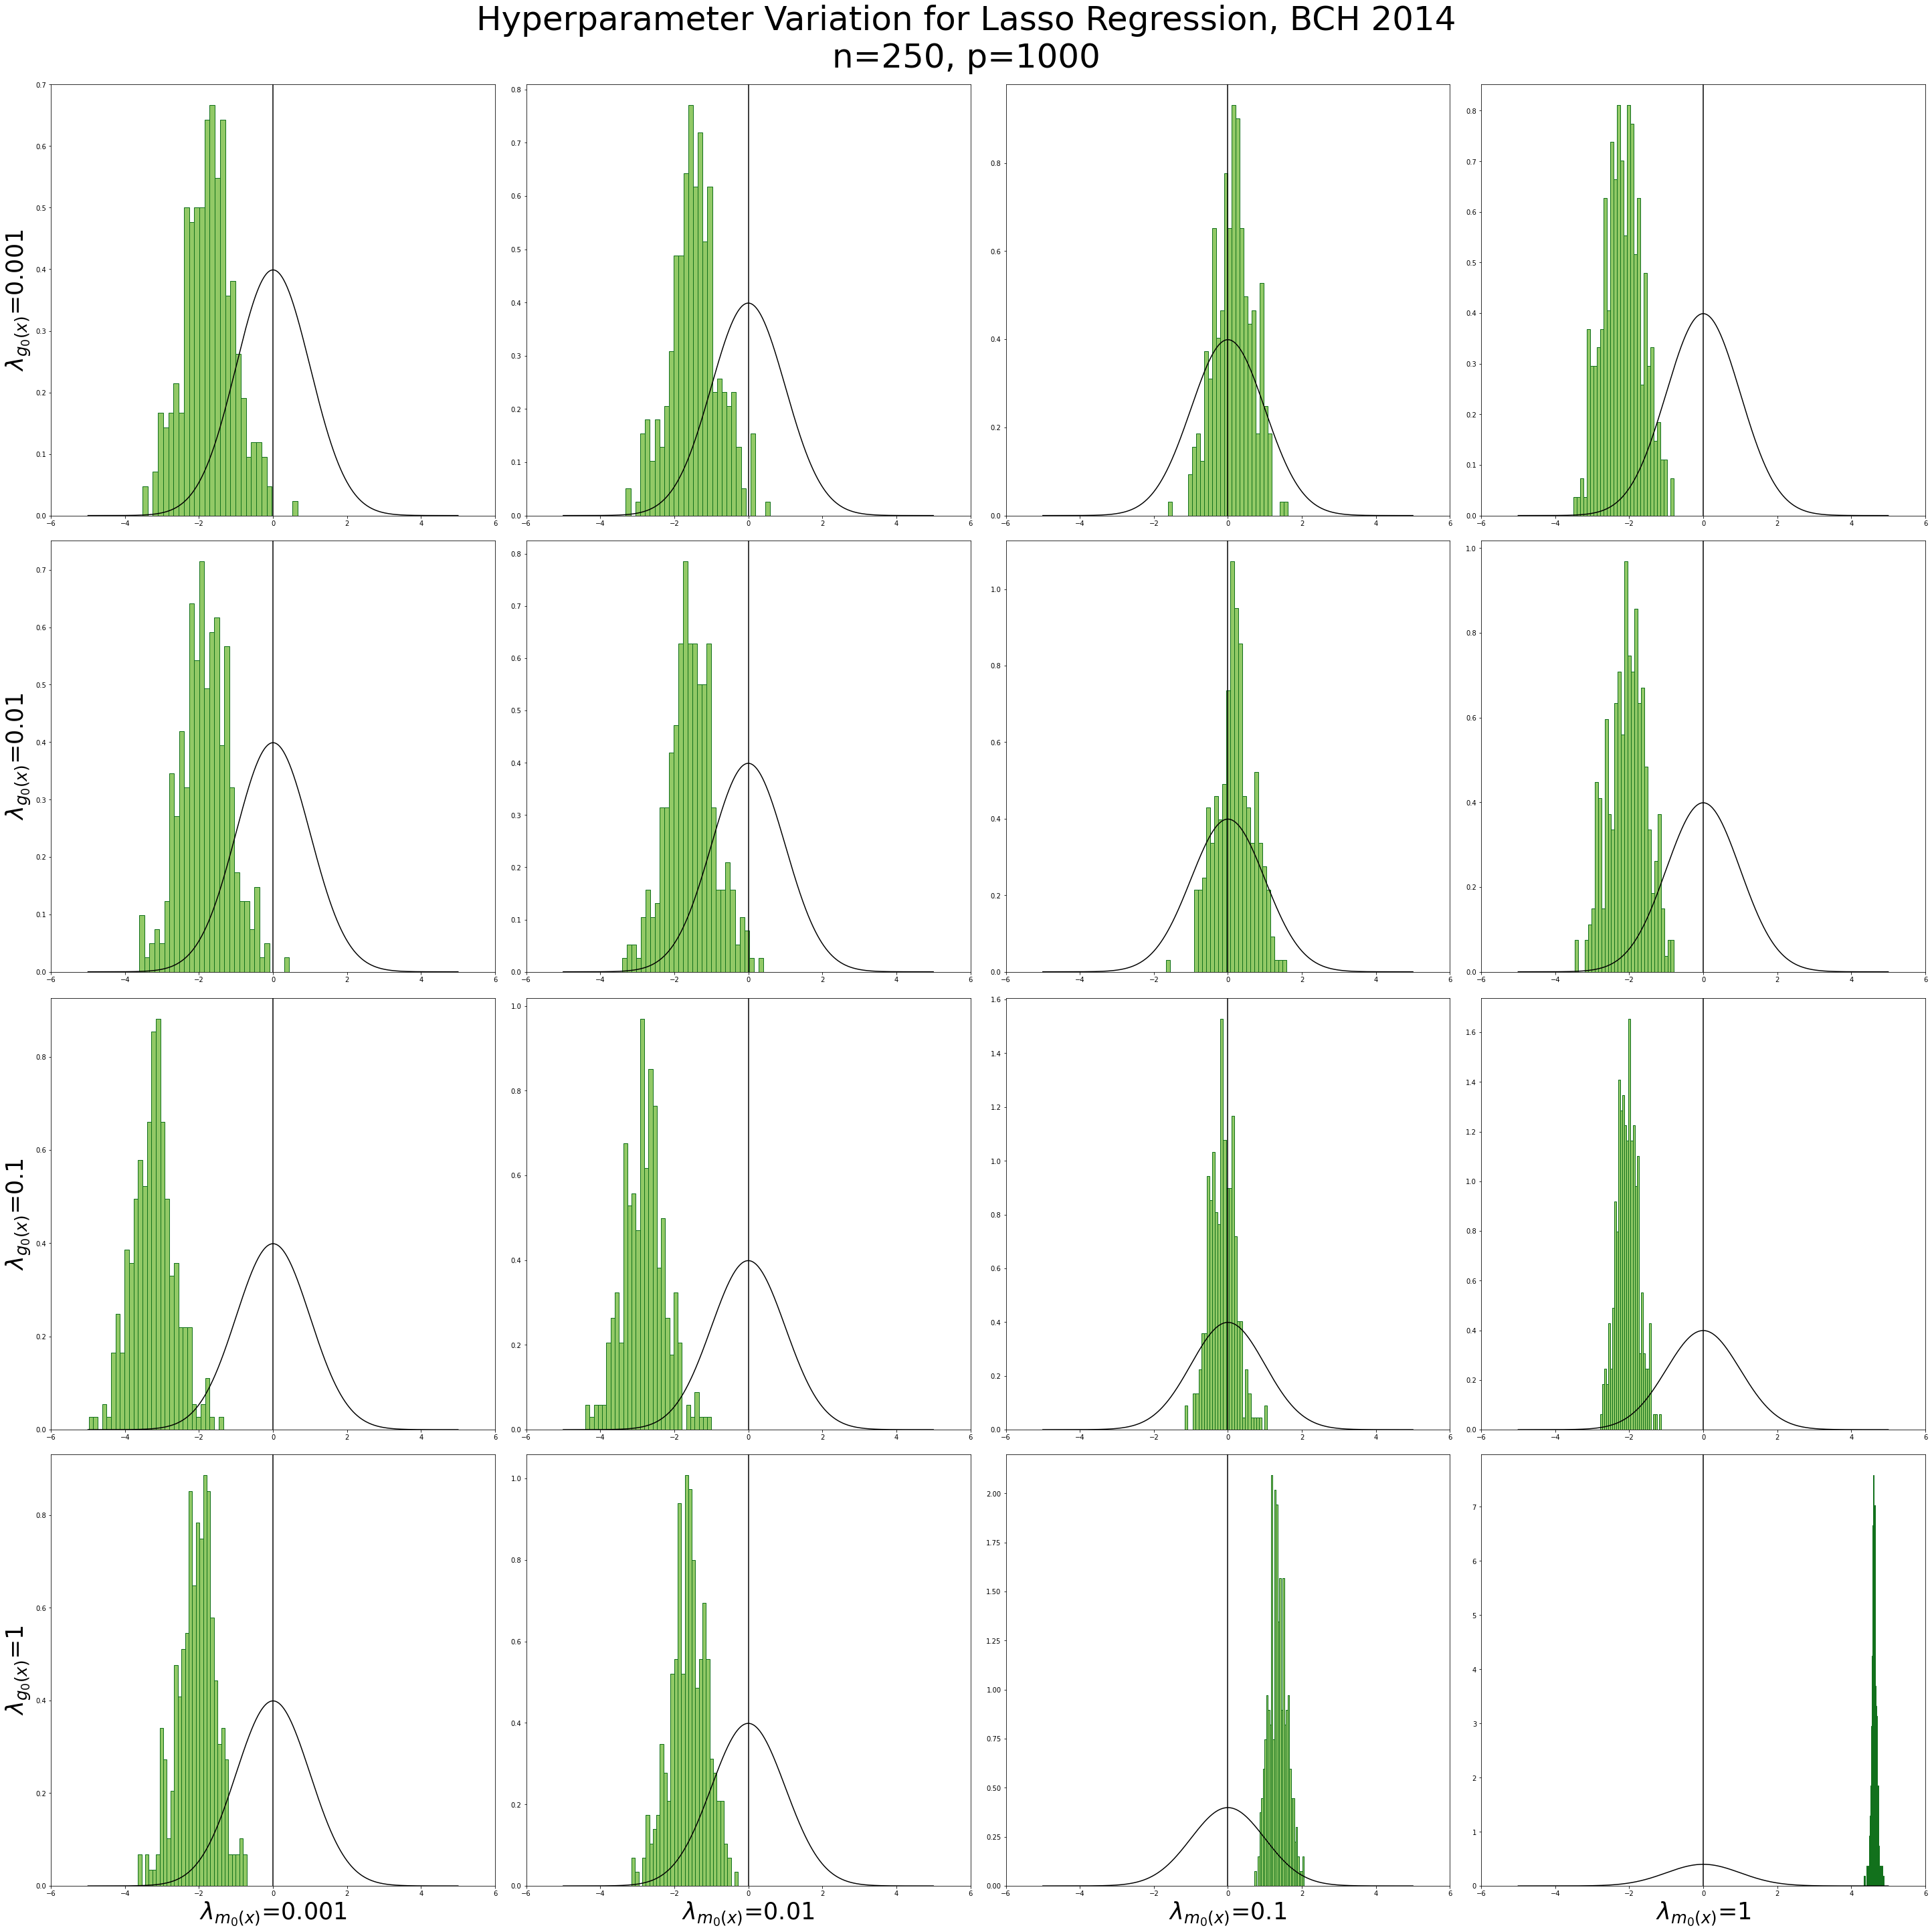

In [6]:
n_obs_wide_2 = 250
dim_x_wide_2 = 1000

data_BCH14_wide_2 = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_wide_2, dim_x=dim_x_wide_2,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

coverage_BCH14_wide_2, bias_BCH14_wide_2 = plot_lasso_variation_results(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l,
                                                                        ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                                                        n_folds=n_folds, data=data_BCH14_wide_2, true_alpha=theta_BCH14,
                                                                        title=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_wide_2}, p={dim_x_wide_2}",
                                                                        filename="lasso_hyperparameter_variation_BCH2014_wide_data_2.png")

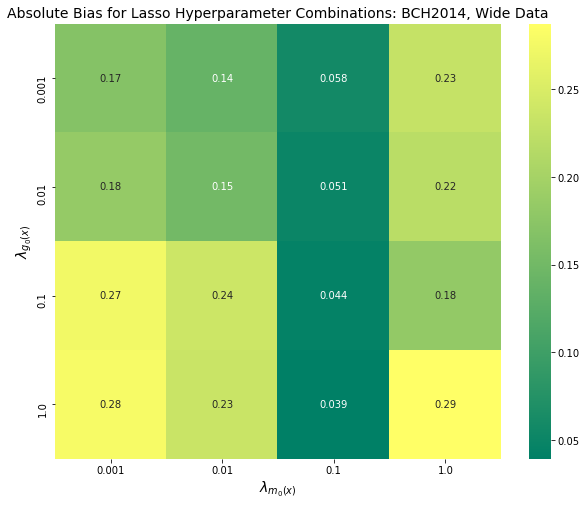

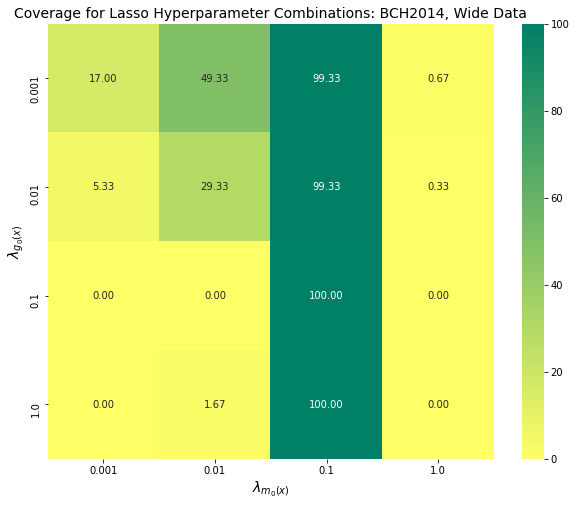

In [32]:
plot_lasso_abs_bias(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    bias_scores=bias_BCH14_wide_2,
                    title="Absolute Bias for Lasso Hyperparameter Combinations: BCH2014, Wide Data",
                    filename="lasso_hyperparameters_bias_BCH2014_wide_2.png")

plot_lasso_coverage(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    coverage_scores=coverage_BCH14_wide_2,
                    title="Coverage for Lasso Hyperparameter Combinations: BCH2014, Wide Data",
                    filename="lasso_hyperparameters_coverage_BCH2014_wide_2.png")

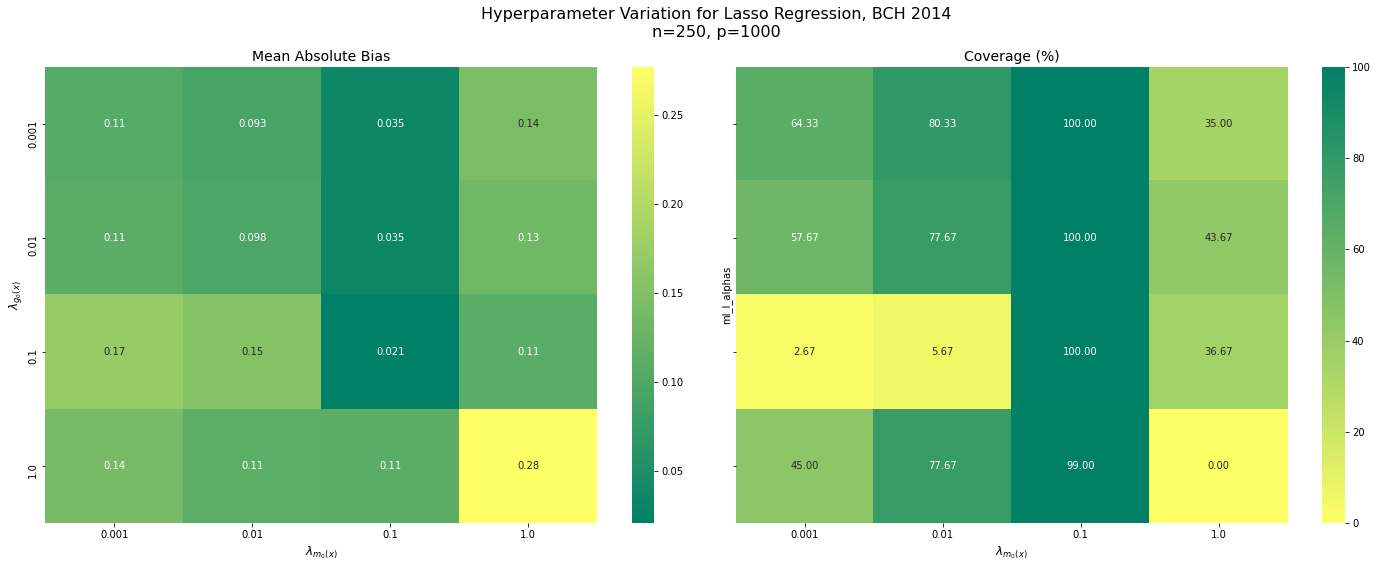

In [7]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                                     ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                     bias_scores=bias_BCH14_wide_2,
                                     coverage_scores=coverage_BCH14_wide_2,
                                     suptitle=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_wide_2}, p={dim_x_wide_2}",
                                     filename="lasso_hyperparameters_bias_coverage_BCH2014_wide_2.png")

## 5.3 Something In Between

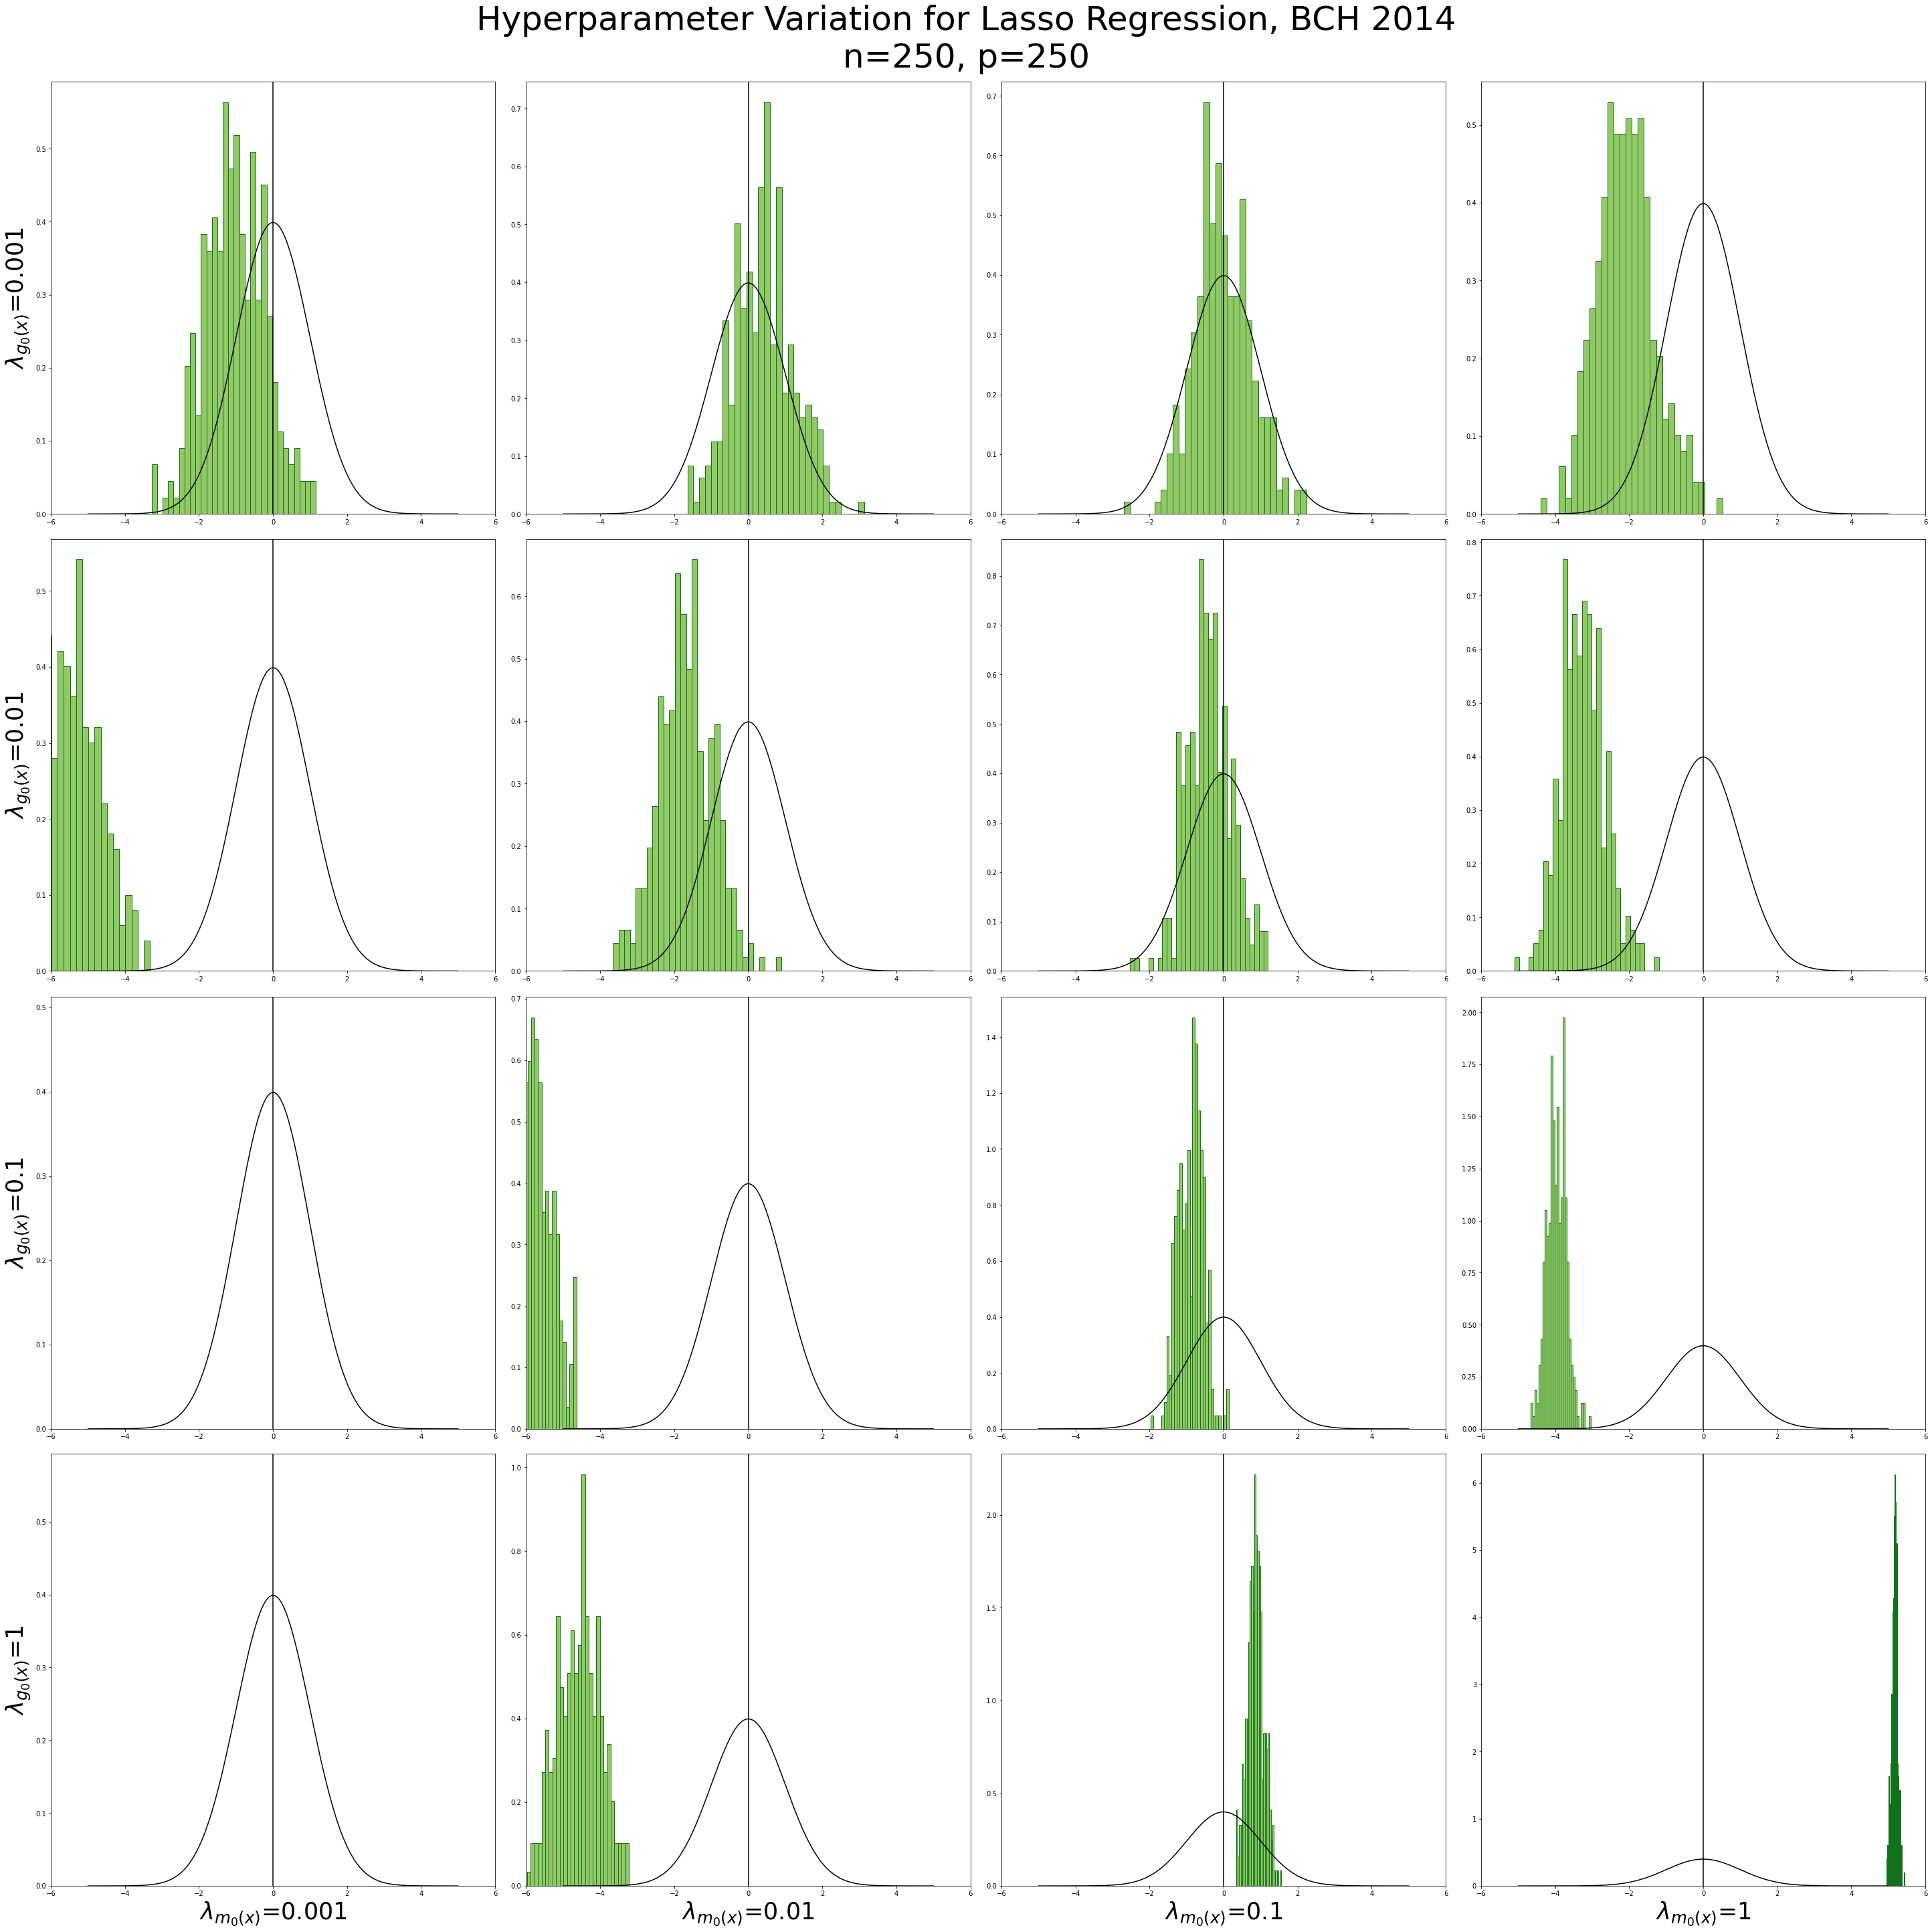

In [8]:
n_obs_quad = 250
dim_x_quad = 250

data_BCH14_quad = make_BCH2014_data_list(n_rep=n_rep_BCH14, theta=theta_BCH14, n_obs=n_obs_quad, dim_x=dim_x_quad,
                                        rho=rho_BCH14, R2_d=R2_d_BCH14, R2_y=R2_y_BCH14, design=design_BCH14, random_seed=random_seed_BCH14)

coverage_BCH14_quad, bias_BCH14_quad = plot_lasso_variation_results(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l,
                                                                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                                                    n_folds=n_folds, data=data_BCH14_quad, true_alpha=theta_BCH14,
                                                                    title=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_quad}, p={dim_x_quad}",
                                                                    filename="lasso_hyperparameter_variation_BCH2014_quad_data.png")

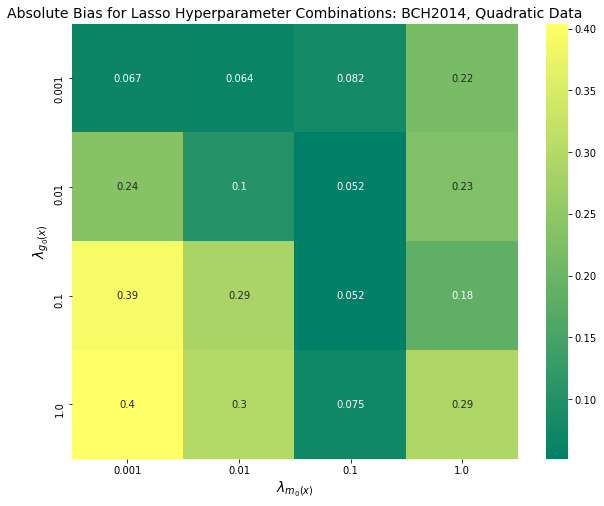

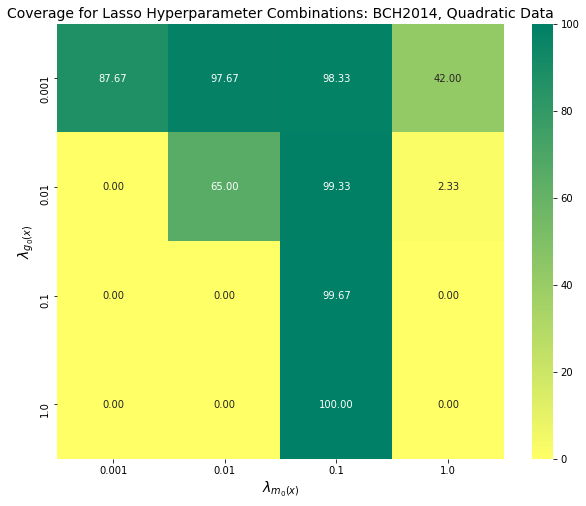

In [9]:
plot_lasso_abs_bias(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    bias_scores=bias_BCH14_quad,
                    title="Absolute Bias for Lasso Hyperparameter Combinations: BCH2014, Quadratic Data",
                    filename="lasso_hyperparameters_bias_BCH2014_quad.png")

plot_lasso_coverage(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                    ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                    coverage_scores=coverage_BCH14_quad,
                    title="Coverage for Lasso Hyperparameter Combinations: BCH2014, Quadratic Data",
                    filename="lasso_hyperparameters_coverage_BCH2014_quad.png")

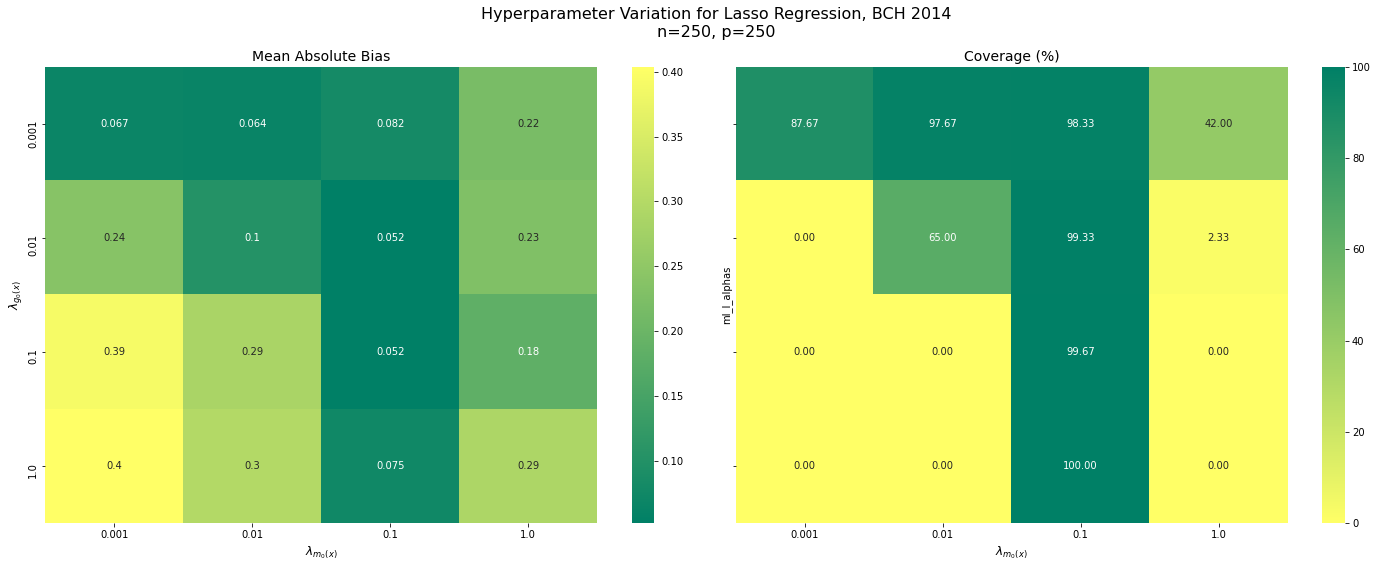

In [10]:
plot_bias_coverage_next_to_eachother(ml_l_hyperparameters=lasso_alpha_hyperparams_ml_l, 
                                     ml_m_hyperparameters=lasso_alpha_hyperparams_ml_m,
                                     bias_scores=bias_BCH14_quad,
                                     coverage_scores=coverage_BCH14_quad,
                                     suptitle=f"Hyperparameter Variation for Lasso Regression, BCH 2014\nn={n_obs_quad}, p={dim_x_quad}",
                                     filename="lasso_hyperparameters_bias_coverage_BCH2014_quad.png")